# Introduction aux Auto-encodeurs avec TensorFlow/Keras

## Objectifs de ce notebook

Dans ce notebook, nous allons explorer les auto-encodeurs, une architecture fondamentale du deep learning pour l'apprentissage non supervisé :

1. **Auto-encodeur Dense (Vanilla)** - L'architecture de base
2. **Auto-encodeur Convolutif** - Optimisé pour les images
3. **Denoising Auto-encodeur** - Robuste au bruit
4. **Visualisation de l'espace latent** - Comprendre les représentations apprises

Nous utiliserons le dataset **Fashion MNIST** pour maintenir la cohérence avec les autres notebooks.

## Qu'est-ce qu'un Auto-encodeur ?

Un auto-encodeur est un réseau de neurones qui apprend à **compresser** puis **reconstruire** ses propres entrées :

```
Input (784) → Encoder → Latent Space (32) → Decoder → Output (784)
```

### Applications pratiques :
- 🎨 **Compression d'images**
- 🔍 **Détection d'anomalies**
- 🧹 **Débruitage d'images**
- 🎭 **Génération de nouvelles données**
- 📊 **Réduction de dimensionnalité**
- 🔐 **Extraction de features pour d'autres tâches**

## 1. Imports et configuration

In [29]:
# Bibliothèques principales
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

# TensorFlow et Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, Model
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.callbacks import Callback

# Utilitaires
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Configuration GPU
try:
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"✅ GPU(s) détecté(s): {len(gpus)} - Croissance mémoire activée")
    else:
        print("ℹ️  Aucun GPU détecté - Utilisation du CPU")
except Exception as e:
    print(f"⚠️  Configuration GPU: {e}")
    print("Utilisation du CPU par défaut")

# Configuration graphiques
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Reproductibilité
np.random.seed(42)
tf.random.set_seed(42)

print(f"\n📦 TensorFlow version: {tf.__version__}")
print(f"📦 Keras version: {keras.__version__}")

ℹ️  Aucun GPU détecté - Utilisation du CPU

📦 TensorFlow version: 2.20.0
📦 Keras version: 3.12.0


## 2. Chargement et préparation des données

### 2.1 Chargement du dataset

In [30]:
# Chargement
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# Noms des classes
class_names = ['T-shirt/top', 'Pantalon', 'Pull', 'Robe', 'Manteau',
               'Sandale', 'Chemise', 'Basket', 'Sac', 'Bottine']

print(f"📊 Forme des données d'entraînement: {X_train.shape}")
print(f"📊 Forme des données de test: {X_test.shape}")
print(f"📊 Plage des valeurs: [{X_train.min()}, {X_train.max()}]")
print(f"\n💡 Pour les auto-encodeurs, nous n'utiliserons PAS les labels (apprentissage non supervisé)")

📊 Forme des données d'entraînement: (60000, 28, 28)
📊 Forme des données de test: (10000, 28, 28)
📊 Plage des valeurs: [0, 255]

💡 Pour les auto-encodeurs, nous n'utiliserons PAS les labels (apprentissage non supervisé)


### 2.2 Visualisation du dataset

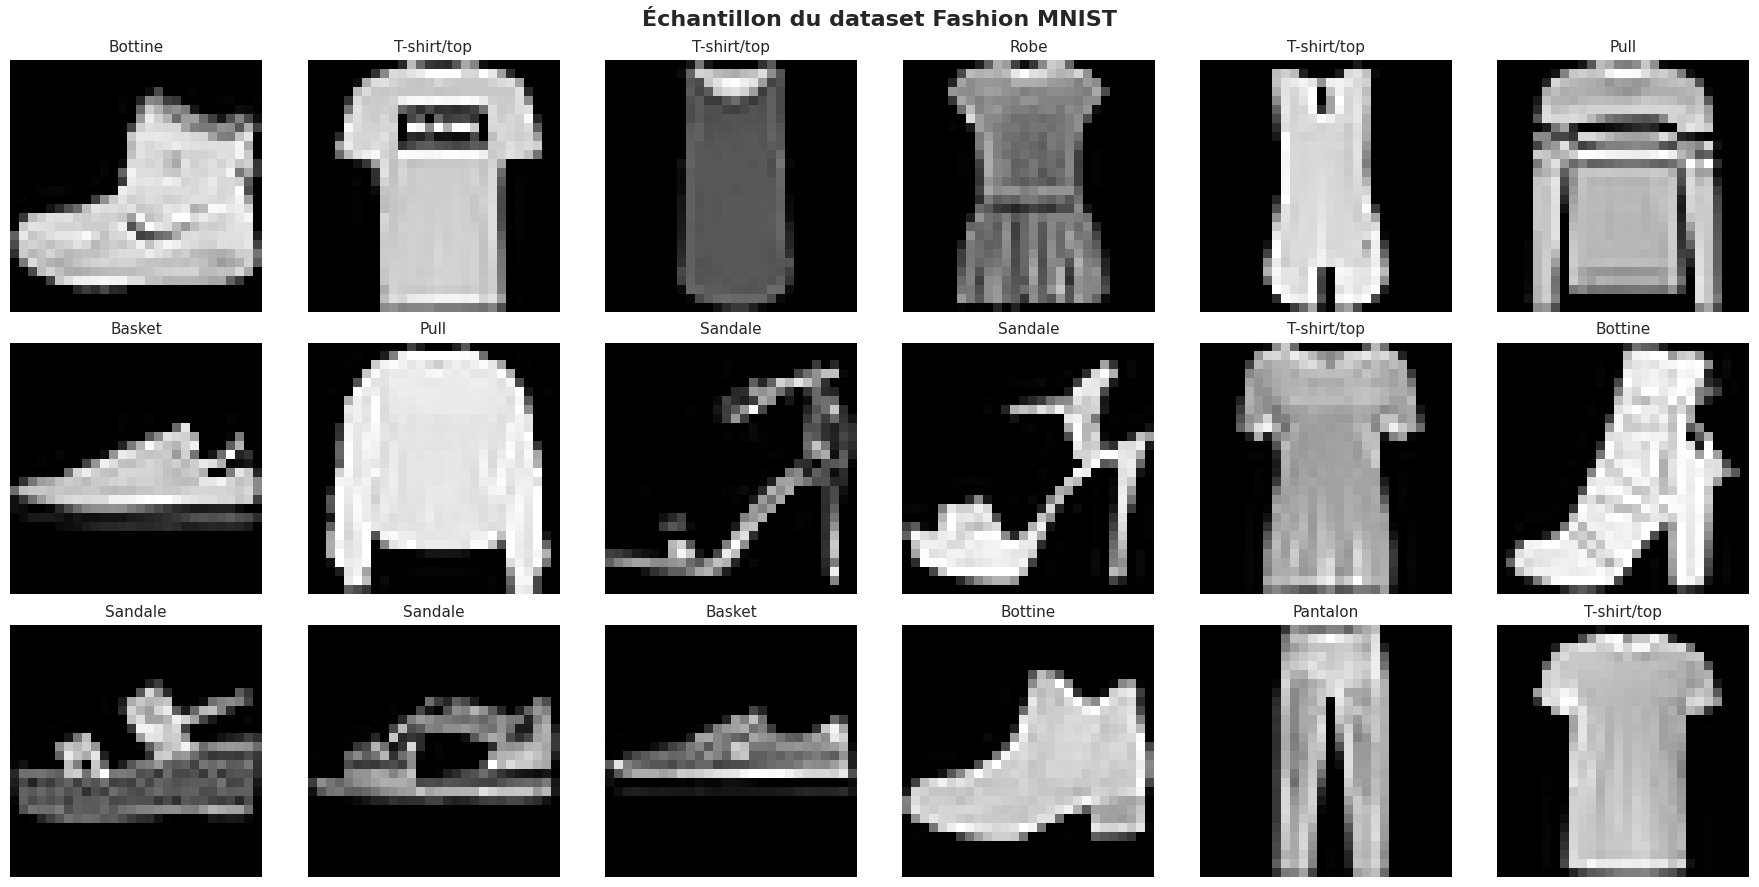

In [31]:
# Visualisation
fig, axes = plt.subplots(3, 6, figsize=(18, 9))
fig.suptitle('Échantillon du dataset Fashion MNIST', fontsize=16, fontweight='bold')

for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[i], cmap='gray')
    ax.set_title(f'{class_names[y_train[i]]}', fontsize=11)
    ax.axis('off')

plt.tight_layout()
plt.show()

### 2.3 Normalisation des données

**Important** : La normalisation est cruciale pour les auto-encodeurs :
- Valeurs entre 0 et 1
- Facilite la convergence
- Permet d'utiliser une fonction d'activation sigmoid en sortie

In [32]:
# Normalisation
X_train_normalized = X_train.astype('float32') / 255.0
X_test_normalized = X_test.astype('float32') / 255.0

print(f"✅ Normalisation effectuée")
print(f"Nouvelles valeurs - Min: {X_train_normalized.min():.2f}, Max: {X_train_normalized.max():.2f}")
print(f"Moyenne: {X_train_normalized.mean():.4f}, Écart-type: {X_train_normalized.std():.4f}")

✅ Normalisation effectuée
Nouvelles valeurs - Min: 0.00, Max: 1.00
Moyenne: 0.2860, Écart-type: 0.3530


### 2.4 Création d'un set de validation

In [33]:
# Split train/validation
X_val = X_train_normalized[50000:]
X_train_final = X_train_normalized[:50000]

# Labels pour l'analyse (pas pour l'entraînement)
y_val = y_train[50000:]
y_train_final = y_train[:50000]

print(f"📦 Données d'entraînement: {X_train_final.shape[0]:,} exemples")
print(f"📦 Données de validation: {X_val.shape[0]:,} exemples")
print(f"📦 Données de test: {X_test_normalized.shape[0]:,} exemples")

📦 Données d'entraînement: 50,000 exemples
📦 Données de validation: 10,000 exemples
📦 Données de test: 10,000 exemples


## 3. Callback personnalisé pour visualisation

Ce callback affiche les reconstructions en temps réel pendant l'entraînement.

In [34]:
class AutoencoderVisualizationCallback(Callback):
    """
    Callback pour visualiser les reconstructions et les métriques en temps réel.
    """
    def __init__(self, validation_data, n_images=8):
        super().__init__()
        self.validation_data = validation_data
        self.n_images = n_images
        # Sélection d'images pour visualisation
        self.test_images = validation_data[:n_images]
        
    def on_train_begin(self, logs=None):
        self.epochs = []
        self.loss = []
        self.val_loss = []
        
    def on_epoch_end(self, epoch, logs=None):
        # Enregistrement des métriques
        self.epochs.append(epoch + 1)
        self.loss.append(logs.get('loss'))
        self.val_loss.append(logs.get('val_loss'))
        
        # Effacement et redessin
        clear_output(wait=True)
        
        # Création de la figure
        fig = plt.figure(figsize=(20, 8))
        gs = fig.add_gridspec(3, self.n_images + 1, hspace=0.3, wspace=0.3)
        
        # Graphique de la loss (prend 2 colonnes)
        ax_loss = fig.add_subplot(gs[:, 0])
        ax_loss.plot(self.epochs, self.loss, 'o-', label='Loss Train', 
                    linewidth=2.5, markersize=8, color='#2E86AB')
        ax_loss.plot(self.epochs, self.val_loss, 's-', label='Loss Validation', 
                    linewidth=2.5, markersize=8, color='#A23B72')
        ax_loss.set_xlabel('Epoch', fontsize=12, fontweight='bold')
        ax_loss.set_ylabel('Loss (MSE)', fontsize=12, fontweight='bold')
        ax_loss.set_title('Évolution de la Loss', fontsize=14, fontweight='bold')
        ax_loss.legend(fontsize=10)
        ax_loss.grid(alpha=0.3)
        
        # Prédictions
        reconstructed = self.model.predict(self.test_images, verbose=0)
        
        # Images originales
        for i in range(self.n_images):
            ax = fig.add_subplot(gs[0, i + 1])
            img = self.test_images[i].reshape(28, 28)
            ax.imshow(img, cmap='gray')
            if i == 0:
                ax.set_ylabel('Original', fontsize=11, fontweight='bold')
            ax.set_xticks([])
            ax.set_yticks([])
        
        # Images reconstruites
        for i in range(self.n_images):
            ax = fig.add_subplot(gs[1, i + 1])
            img = reconstructed[i].reshape(28, 28)
            ax.imshow(img, cmap='gray')
            if i == 0:
                ax.set_ylabel('Reconstruit', fontsize=11, fontweight='bold')
            ax.set_xticks([])
            ax.set_yticks([])
        
        # Différence (erreur)
        for i in range(self.n_images):
            ax = fig.add_subplot(gs[2, i + 1])
            original = self.test_images[i].reshape(28, 28)
            reconstructed_img = reconstructed[i].reshape(28, 28)
            diff = np.abs(original - reconstructed_img)
            im = ax.imshow(diff, cmap='hot', vmin=0, vmax=1)
            if i == 0:
                ax.set_ylabel('Erreur', fontsize=11, fontweight='bold')
            ax.set_xticks([])
            ax.set_yticks([])
        
        plt.suptitle(f'Auto-encodeur - Epoch {epoch + 1}/{self.params["epochs"]}', 
                    fontsize=16, fontweight='bold', y=0.98)
        plt.show()
        
        # Affichage textuel
        print(f"\nEpoch {epoch + 1}/{self.params['epochs']}")
        print(f"Loss: {logs.get('loss'):.6f} - Val Loss: {logs.get('val_loss'):.6f}")
        
        # Calcul de l'erreur moyenne de reconstruction
        mse = np.mean((self.test_images - reconstructed) ** 2)
        print(f"MSE moyenne sur échantillon: {mse:.6f}")

---

# PARTIE 1 : AUTO-ENCODEUR DENSE (VANILLA)

## 4. Architecture de l'auto-encodeur dense

### Principe de fonctionnement

Un auto-encodeur dense se compose de deux parties :

1. **Encoder** : Compresse l'entrée vers une représentation latente
   ```
   Input (784) → Dense(256) → Dense(128) → Latent (32)
   ```

2. **Decoder** : Reconstruit l'image à partir de la représentation latente
   ```
   Latent (32) → Dense(128) → Dense(256) → Output (784)
   ```

### Fonction de perte

Pour les auto-encodeurs, on utilise typiquement :
- **MSE (Mean Squared Error)** : Mesure la différence pixel par pixel
- **Binary Crossentropy** : Alternative pour images normalisées [0,1]

### 4.1 Préparation des données pour l'auto-encodeur dense

In [9]:
# Aplatissement des images
X_train_flat = X_train_final.reshape(-1, 28 * 28)
X_val_flat = X_val.reshape(-1, 28 * 28)
X_test_flat = X_test_normalized.reshape(-1, 28 * 28)

print(f"✅ Forme après aplatissement: {X_train_flat.shape}")
print(f"   Chaque image est un vecteur de {28*28} valeurs")

✅ Forme après aplatissement: (50000, 784)
   Chaque image est un vecteur de 784 valeurs


### 4.2 Construction de l'auto-encodeur dense

In [10]:
def create_dense_autoencoder(latent_dim=32):
    """
    Crée un auto-encodeur dense avec une dimension latente configurable.
    
    Args:
        latent_dim: Dimension de l'espace latent (bottleneck)
    
    Returns:
        autoencoder: Modèle complet
        encoder: Partie encoder seule
        decoder: Partie decoder seule
    """
    # === ENCODER ===
    encoder_input = layers.Input(shape=(784,), name='encoder_input')
    x = layers.Dense(256, activation='relu', name='encoder_dense_1')(encoder_input)
    x = layers.Dense(128, activation='relu', name='encoder_dense_2')(x)
    latent = layers.Dense(latent_dim, activation='relu', name='latent_space')(x)
    
    encoder = Model(encoder_input, latent, name='encoder')
    
    # === DECODER ===
    decoder_input = layers.Input(shape=(latent_dim,), name='decoder_input')
    x = layers.Dense(128, activation='relu', name='decoder_dense_1')(decoder_input)
    x = layers.Dense(256, activation='relu', name='decoder_dense_2')(x)
    decoder_output = layers.Dense(784, activation='sigmoid', name='decoder_output')(x)
    
    decoder = Model(decoder_input, decoder_output, name='decoder')
    
    # === AUTOENCODER COMPLET ===
    autoencoder_input = layers.Input(shape=(784,), name='autoencoder_input')
    encoded = encoder(autoencoder_input)
    decoded = decoder(encoded)
    autoencoder = Model(autoencoder_input, decoded, name='autoencoder')
    
    return autoencoder, encoder, decoder

# Création du modèle
latent_dim = 32
dense_autoencoder, dense_encoder, dense_decoder = create_dense_autoencoder(latent_dim)

print("="*70)
print("📊 ARCHITECTURE DE L'AUTO-ENCODEUR DENSE")
print("="*70)
print("\n🔹 ENCODER:")
dense_encoder.summary()
print("\n🔹 DECODER:")
dense_decoder.summary()
print("\n🔹 AUTOENCODER COMPLET:")
dense_autoencoder.summary()

📊 ARCHITECTURE DE L'AUTO-ENCODEUR DENSE

🔹 ENCODER:


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dense_1 (Dense)         │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dense_2 (Dense)         │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_space (Dense)            │ (None, 32)             │         4,128 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 237,984 (929.62 KB)

 Trainable params: 237,984 (929.62 KB)

 Non-trainable params: 0 (0.00 B)


🔹 DECODER:


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_dense_1 (Dense)         │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_dense_2 (Dense)         │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output (Dense)          │ (None, 784)            │       201,488 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 238,736 (932.56 KB)

 Trainable params: 238,736 (932.56 KB)

 Non-trainable params: 0 (0.00 B)


🔹 AUTOENCODER COMPLET:


Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ autoencoder_input (InputLayer)  │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 32)             │       237,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 784)            │       238,736 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 476,720 (1.82 MB)

 Trainable params: 476,720 (1.82 MB)

 Non-trainable params: 0 (0.00 B)

### 4.3 Visualisation de l'architecture

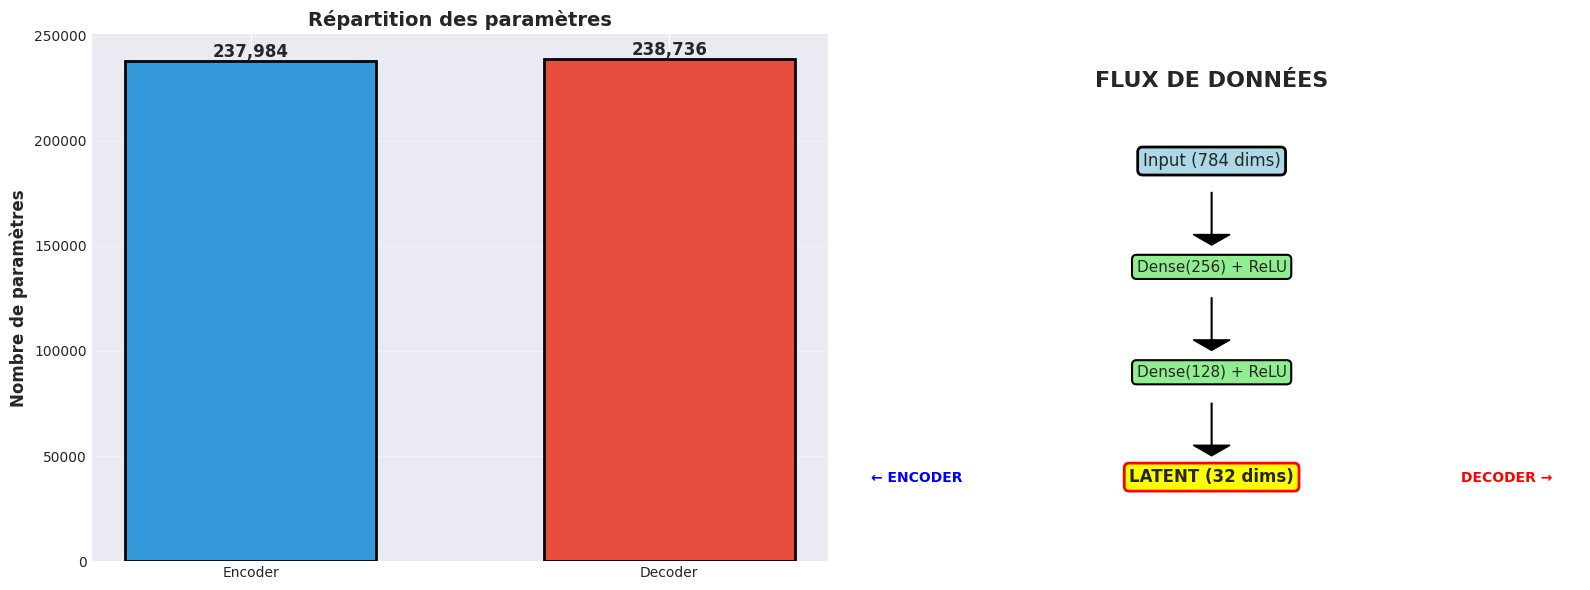


📊 TOTAL PARAMÈTRES : 476,720
   Taux de compression : 784 → 32 (× 24.5)


In [11]:
# Analyse des paramètres
encoder_params = dense_encoder.count_params()
decoder_params = dense_decoder.count_params()
total_params = dense_autoencoder.count_params()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Répartition des paramètres
components = ['Encoder', 'Decoder']
params = [encoder_params, decoder_params]
colors = ['#3498db', '#e74c3c']

bars = ax1.bar(components, params, color=colors, edgecolor='black', linewidth=2, width=0.6)
ax1.set_ylabel('Nombre de paramètres', fontsize=12, fontweight='bold')
ax1.set_title('Répartition des paramètres', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

for bar, param in zip(bars, params):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{param:,}',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

# Diagramme du flux de données
ax2.axis('off')
ax2.text(0.5, 0.9, 'FLUX DE DONNÉES', ha='center', fontsize=16, fontweight='bold')
ax2.text(0.5, 0.75, 'Input (784 dims)', ha='center', fontsize=12, 
        bbox=dict(boxstyle='round', facecolor='lightblue', edgecolor='black', linewidth=2))
ax2.arrow(0.5, 0.70, 0, -0.08, head_width=0.05, head_length=0.02, fc='black', ec='black')
ax2.text(0.5, 0.55, 'Dense(256) + ReLU', ha='center', fontsize=11, 
        bbox=dict(boxstyle='round', facecolor='lightgreen', edgecolor='black', linewidth=1.5))
ax2.arrow(0.5, 0.50, 0, -0.08, head_width=0.05, head_length=0.02, fc='black', ec='black')
ax2.text(0.5, 0.35, 'Dense(128) + ReLU', ha='center', fontsize=11, 
        bbox=dict(boxstyle='round', facecolor='lightgreen', edgecolor='black', linewidth=1.5))
ax2.arrow(0.5, 0.30, 0, -0.08, head_width=0.05, head_length=0.02, fc='black', ec='black')
ax2.text(0.5, 0.15, f'LATENT ({latent_dim} dims)', ha='center', fontsize=12, fontweight='bold',
        bbox=dict(boxstyle='round', facecolor='yellow', edgecolor='red', linewidth=2))
ax2.text(0.1, 0.15, '← ENCODER', ha='center', fontsize=10, color='blue', fontweight='bold')
ax2.text(0.9, 0.15, 'DECODER →', ha='center', fontsize=10, color='red', fontweight='bold')
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)

plt.tight_layout()
plt.show()

print(f"\n{'='*70}")
print(f"📊 TOTAL PARAMÈTRES : {total_params:,}")
print(f"   Taux de compression : 784 → {latent_dim} (× {784/latent_dim:.1f})")
print(f"{'='*70}")

### 4.4 Compilation du modèle

In [12]:
# Compilation
dense_autoencoder.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',  # Ou 'mse' pour Mean Squared Error
    metrics=['mse']  # On suit aussi la MSE
)

print("✅ Auto-encodeur compilé")
print(f"   Optimiseur: Adam (lr=0.001)")
print(f"   Loss: Binary Crossentropy")
print(f"   Métrique: MSE")

✅ Auto-encodeur compilé
   Optimiseur: Adam (lr=0.001)
   Loss: Binary Crossentropy
   Métrique: MSE


### 4.5 Entraînement de l'auto-encodeur dense

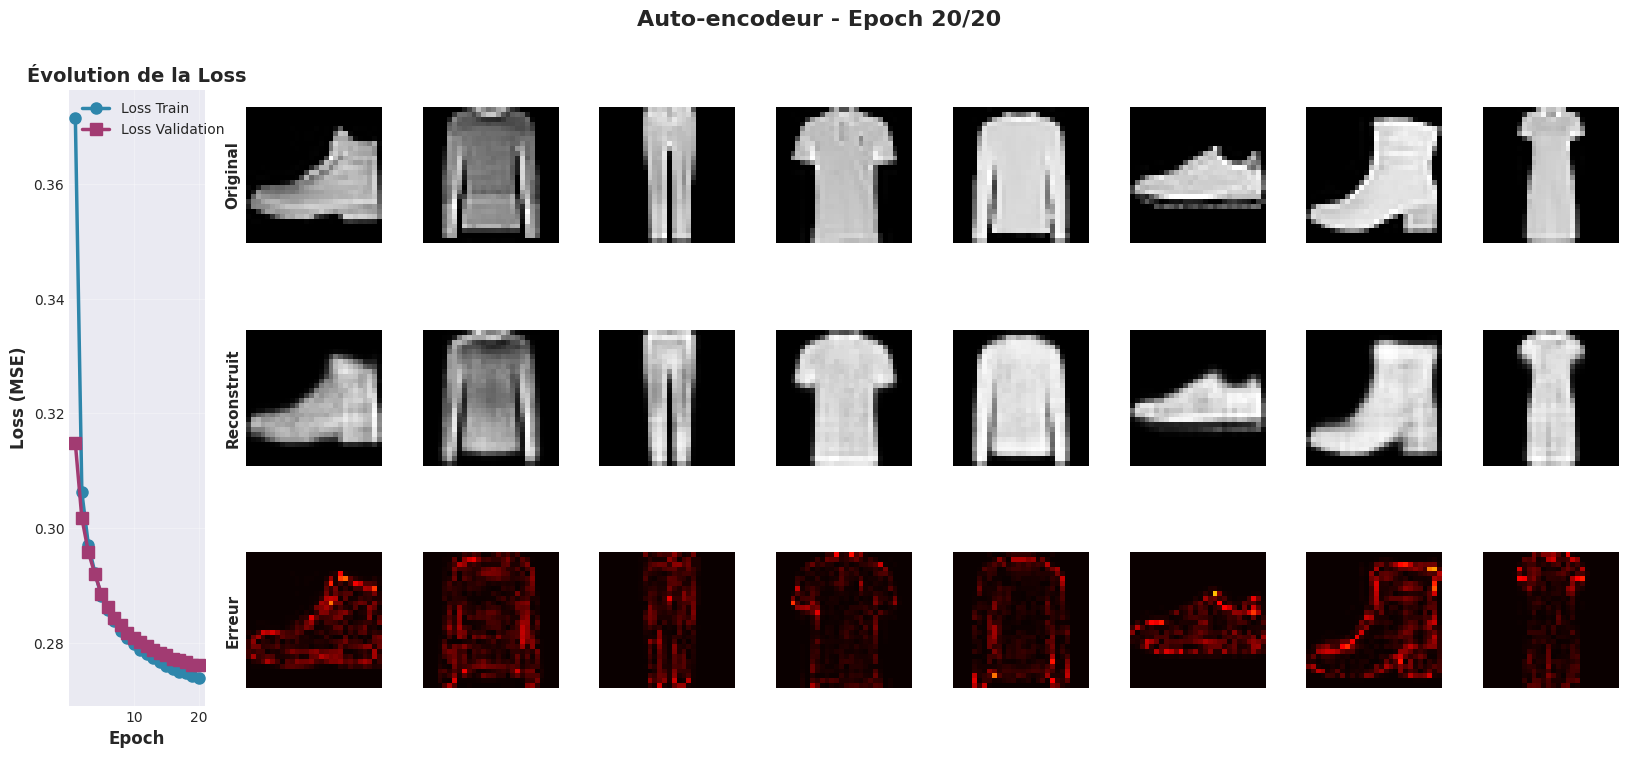


Epoch 20/20
Loss: 0.273891 - Val Loss: 0.276021
MSE moyenne sur échantillon: 0.005123

✅ Entraînement terminé !


In [13]:
# Création du callback de visualisation
viz_callback = AutoencoderVisualizationCallback(X_val_flat, n_images=8)

print("🚀 Début de l'entraînement de l'auto-encodeur DENSE...\n")

# Entraînement
# Note: Pour l'auto-encodeur, X = Y (on reconstruit l'entrée)
history_dense = dense_autoencoder.fit(
    X_train_flat, X_train_flat,  # Input = Output
    validation_data=(X_val_flat, X_val_flat),
    epochs=20,
    batch_size=256,
    callbacks=[viz_callback],
    verbose=0
)

print("\n✅ Entraînement terminé !")

### 4.6 Évaluation de l'auto-encodeur dense

📊 RÉSULTATS - AUTO-ENCODEUR DENSE
Loss sur le test (Binary Crossentropy): 0.276847
MSE sur le test: 0.011124
RMSE sur le test: 0.105469


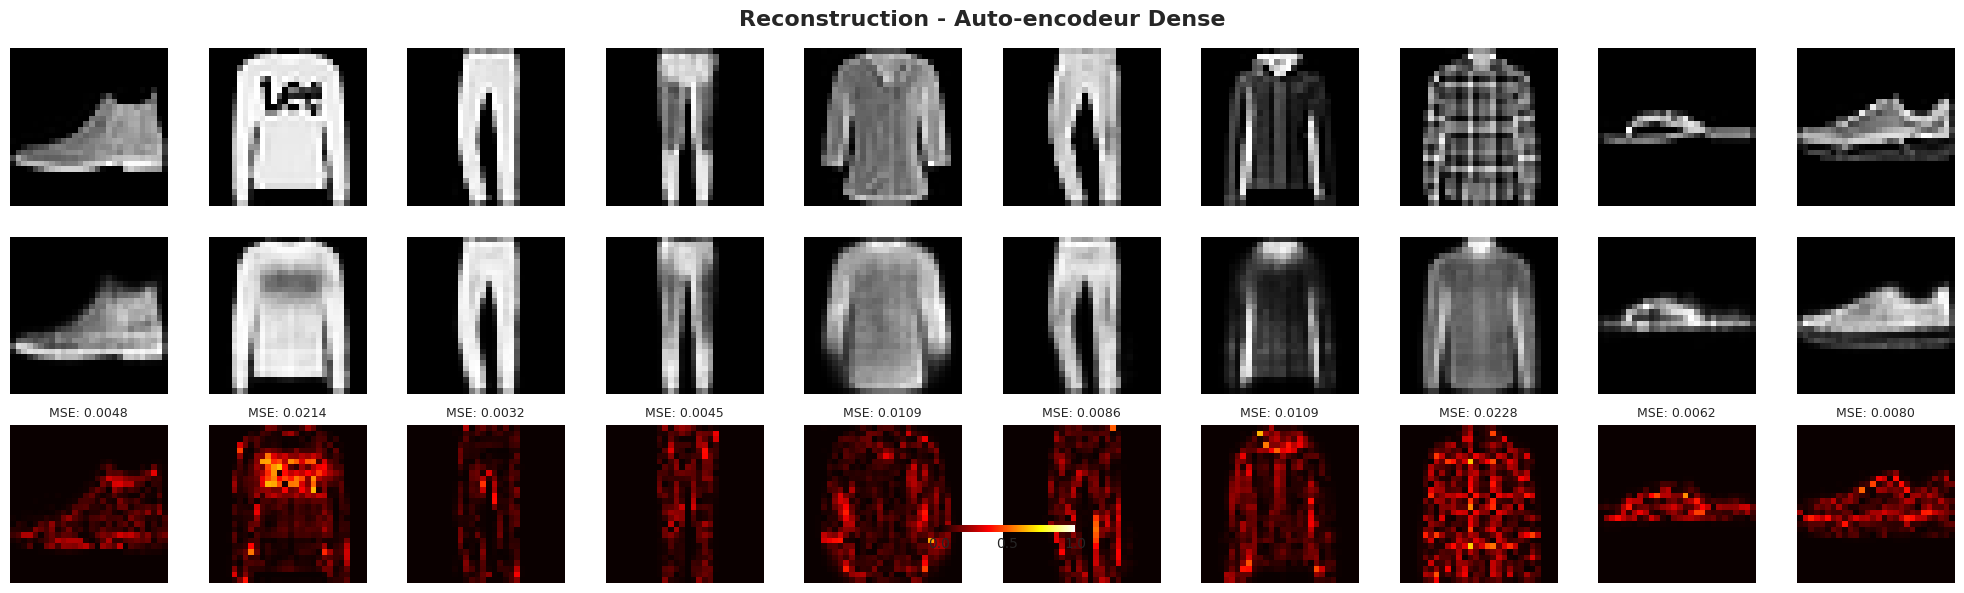

In [14]:
# Évaluation sur le set de test
test_loss, test_mse = dense_autoencoder.evaluate(X_test_flat, X_test_flat, verbose=0)

# Reconstruction d'exemples
n_examples = 10
test_sample = X_test_flat[:n_examples]
reconstructed = dense_autoencoder.predict(test_sample, verbose=0)

print("="*70)
print("📊 RÉSULTATS - AUTO-ENCODEUR DENSE")
print("="*70)
print(f"Loss sur le test (Binary Crossentropy): {test_loss:.6f}")
print(f"MSE sur le test: {test_mse:.6f}")
print(f"RMSE sur le test: {np.sqrt(test_mse):.6f}")
print("="*70)

# Visualisation détaillée
fig, axes = plt.subplots(3, n_examples, figsize=(20, 6))
fig.suptitle('Reconstruction - Auto-encodeur Dense', fontsize=16, fontweight='bold')

for i in range(n_examples):
    # Original
    axes[0, i].imshow(test_sample[i].reshape(28, 28), cmap='gray')
    axes[0, i].axis('off')
    if i == 0:
        axes[0, i].set_ylabel('Original', fontsize=12, fontweight='bold')
    
    # Reconstruit
    axes[1, i].imshow(reconstructed[i].reshape(28, 28), cmap='gray')
    axes[1, i].axis('off')
    if i == 0:
        axes[1, i].set_ylabel('Reconstruit', fontsize=12, fontweight='bold')
    
    # Différence
    diff = np.abs(test_sample[i].reshape(28, 28) - reconstructed[i].reshape(28, 28))
    im = axes[2, i].imshow(diff, cmap='hot', vmin=0, vmax=1)
    axes[2, i].axis('off')
    if i == 0:
        axes[2, i].set_ylabel('Erreur', fontsize=12, fontweight='bold')
    
    # MSE pour cette image
    mse_img = np.mean((test_sample[i] - reconstructed[i]) ** 2)
    axes[2, i].set_title(f'MSE: {mse_img:.4f}', fontsize=9)

# Colorbar
fig.colorbar(im, ax=axes[2, :], orientation='horizontal', pad=0.05, fraction=0.05)

plt.tight_layout()
plt.show()

### 4.7 Visualisation de l'espace latent

L'espace latent est la représentation compressée apprise par l'encoder. Visualisons-le avec t-SNE.

⏳ Encodage des données de test...
✅ Forme de l'espace latent: (10000, 32)
⏳ Réduction de dimension avec t-SNE (cela peut prendre 1-2 minutes)...
✅ t-SNE terminé


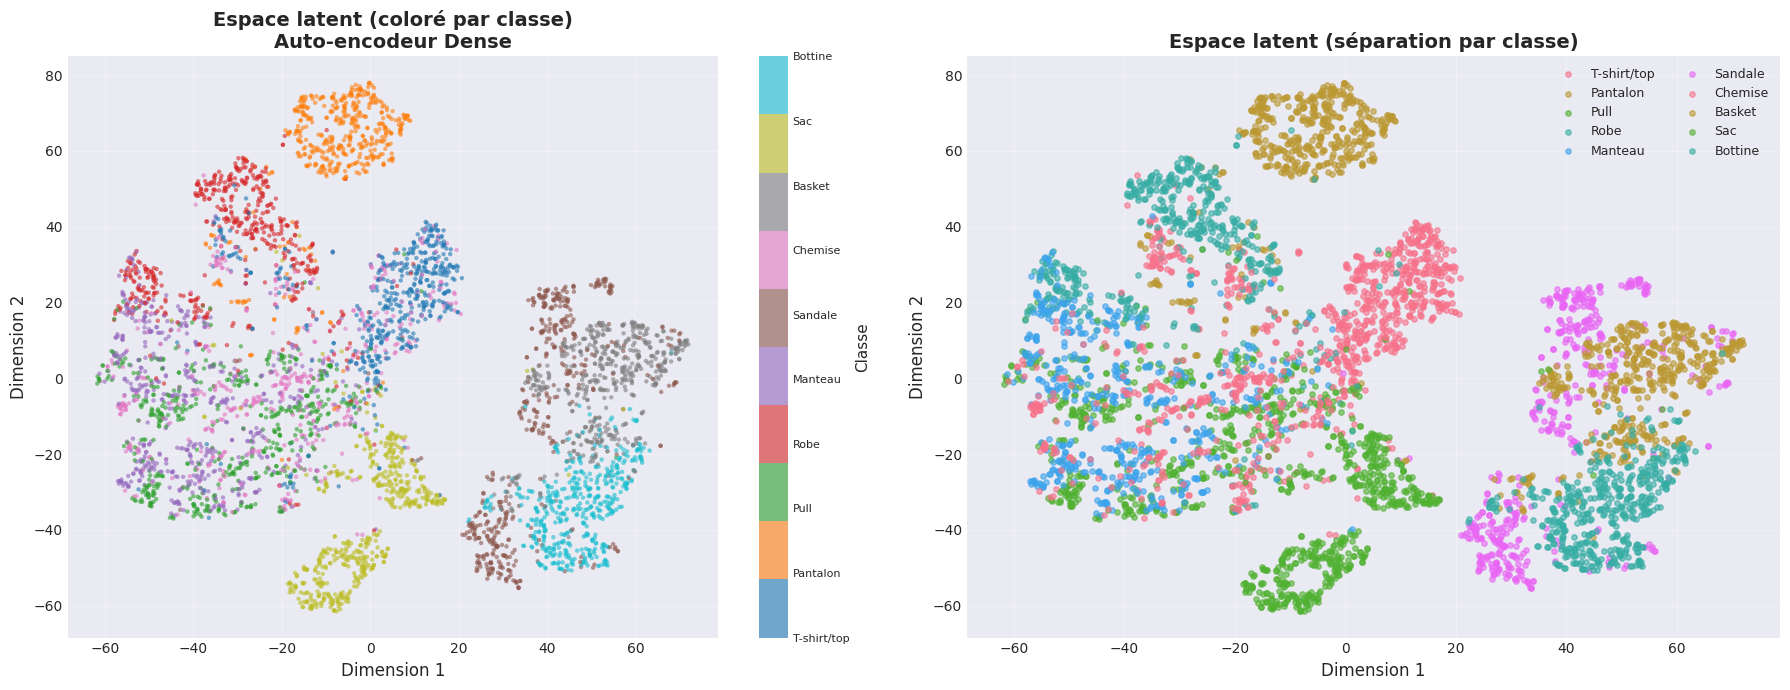


💡 INTERPRÉTATION:
   - Les points proches dans l'espace latent représentent des images similaires
   - Un bon auto-encodeur groupe naturellement les classes similaires
   - On peut voir des clusters même sans supervision !


In [15]:
# Encodage du set de test
print("⏳ Encodage des données de test...")
latent_representations = dense_encoder.predict(X_test_flat, verbose=0)
print(f"✅ Forme de l'espace latent: {latent_representations.shape}")

# Réduction avec t-SNE pour visualisation 2D
print("⏳ Réduction de dimension avec t-SNE (cela peut prendre 1-2 minutes)...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
latent_2d = tsne.fit_transform(latent_representations[:5000])  # Sur 5000 exemples
print("✅ t-SNE terminé")

# Visualisation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# Visualisation colorée par classe
scatter = ax1.scatter(latent_2d[:, 0], latent_2d[:, 1], 
                     c=y_test[:5000], cmap='tab10', 
                     alpha=0.6, s=10, edgecolors='none')
ax1.set_title('Espace latent (coloré par classe)\nAuto-encodeur Dense', 
             fontsize=14, fontweight='bold')
ax1.set_xlabel('Dimension 1', fontsize=12)
ax1.set_ylabel('Dimension 2', fontsize=12)
cbar = plt.colorbar(scatter, ax=ax1, ticks=range(10))
cbar.set_label('Classe', fontsize=11)
cbar.ax.set_yticklabels(class_names, fontsize=8)
ax1.grid(alpha=0.3)

# Distribution par classe
for i in range(10):
    mask = y_test[:5000] == i
    ax2.scatter(latent_2d[mask, 0], latent_2d[mask, 1], 
               label=class_names[i], alpha=0.6, s=15)
ax2.set_title('Espace latent (séparation par classe)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Dimension 1', fontsize=12)
ax2.set_ylabel('Dimension 2', fontsize=12)
ax2.legend(loc='best', fontsize=9, ncol=2)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 INTERPRÉTATION:")
print("   - Les points proches dans l'espace latent représentent des images similaires")
print("   - Un bon auto-encodeur groupe naturellement les classes similaires")
print("   - On peut voir des clusters même sans supervision !")

---

# PARTIE 2 : AUTO-ENCODEUR CONVOLUTIF

## 5. Architecture de l'auto-encodeur convolutif

### Pourquoi utiliser des convolutions ?

Les auto-encodeurs convolutifs sont plus adaptés aux images car ils :
- ✅ **Préservent la structure spatiale**
- ✅ **Utilisent moins de paramètres**
- ✅ **Capturent mieux les features locales**
- ✅ **Produisent des reconstructions plus nettes**

### Architecture

```
Encoder:
Input (28×28×1) → Conv2D(32) + MaxPool → Conv2D(64) + MaxPool → Flatten → Dense(latent_dim)

Decoder:
Dense → Reshape → Conv2DTranspose(64) → Conv2DTranspose(32) → Conv2D(1)
```

### 5.1 Préparation des données pour CNN

In [16]:
# Ajout de la dimension des canaux
X_train_cnn = X_train_final.reshape(-1, 28, 28, 1)
X_val_cnn = X_val.reshape(-1, 28, 28, 1)
X_test_cnn = X_test_normalized.reshape(-1, 28, 28, 1)

print(f"✅ Forme pour CNN: {X_train_cnn.shape}")
print(f"   Format: (nombre_images, hauteur, largeur, canaux)")

✅ Forme pour CNN: (50000, 28, 28, 1)
   Format: (nombre_images, hauteur, largeur, canaux)


### 5.2 Construction de l'auto-encodeur convolutif

In [17]:
def create_convolutional_autoencoder(latent_dim=64):
    """
    Crée un auto-encodeur convolutif.
    
    Args:
        latent_dim: Dimension de l'espace latent
    
    Returns:
        autoencoder, encoder, decoder
    """
    # === ENCODER ===
    encoder_input = layers.Input(shape=(28, 28, 1), name='encoder_input')
    
    # Bloc convolutif 1
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='conv1')(encoder_input)
    x = layers.MaxPooling2D((2, 2), padding='same', name='pool1')(x)  # 14x14
    
    # Bloc convolutif 2
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv2')(x)
    x = layers.MaxPooling2D((2, 2), padding='same', name='pool2')(x)  # 7x7
    
    # Aplatissement et compression vers l'espace latent
    x = layers.Flatten(name='flatten')(x)
    latent = layers.Dense(latent_dim, activation='relu', name='latent_space')(x)
    
    encoder = Model(encoder_input, latent, name='conv_encoder')
    
    # === DECODER ===
    decoder_input = layers.Input(shape=(latent_dim,), name='decoder_input')
    
    # Expansion et reshape
    x = layers.Dense(7 * 7 * 64, activation='relu', name='dense_decoder')(decoder_input)
    x = layers.Reshape((7, 7, 64), name='reshape')(x)
    
    # Déconvolution 1 (upsampling)
    x = layers.Conv2DTranspose(64, (3, 3), activation='relu', strides=2, 
                               padding='same', name='deconv1')(x)  # 14x14
    
    # Déconvolution 2 (upsampling)
    x = layers.Conv2DTranspose(32, (3, 3), activation='relu', strides=2, 
                               padding='same', name='deconv2')(x)  # 28x28
    
    # Couche de sortie
    decoder_output = layers.Conv2D(1, (3, 3), activation='sigmoid', 
                                   padding='same', name='output')(x)
    
    decoder = Model(decoder_input, decoder_output, name='conv_decoder')
    
    # === AUTOENCODER COMPLET ===
    autoencoder_input = layers.Input(shape=(28, 28, 1), name='autoencoder_input')
    encoded = encoder(autoencoder_input)
    decoded = decoder(encoded)
    autoencoder = Model(autoencoder_input, decoded, name='conv_autoencoder')
    
    return autoencoder, encoder, decoder

# Création du modèle
conv_latent_dim = 64
conv_autoencoder, conv_encoder, conv_decoder = create_convolutional_autoencoder(conv_latent_dim)

print("="*70)
print("📊 ARCHITECTURE DE L'AUTO-ENCODEUR CONVOLUTIF")
print("="*70)
print("\n🔹 ENCODER:")
conv_encoder.summary()
print("\n🔹 DECODER:")
conv_decoder.summary()

📊 ARCHITECTURE DE L'AUTO-ENCODEUR CONVOLUTIF

🔹 ENCODER:


Model: "conv_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_space (Dense)            │ (None, 64)             │       200,768 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 219,584 (857.75 KB)

 Trainable params: 219,584 (857.75 KB)

 Non-trainable params: 0 (0.00 B)


🔹 DECODER:


Model: "conv_decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_decoder (Dense)           │ (None, 3136)           │       203,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ deconv1 (Conv2DTranspose)       │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ deconv2 (Conv2DTranspose)       │ (None, 28, 28, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Conv2D)                 │ (None, 28, 28, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 259,521 (1013.75 KB)

 Trainable params: 259,521 (1013.75 KB)

 Non-trainable params: 0 (0.00 B)

### 5.3 Comparaison Dense vs Convolutif

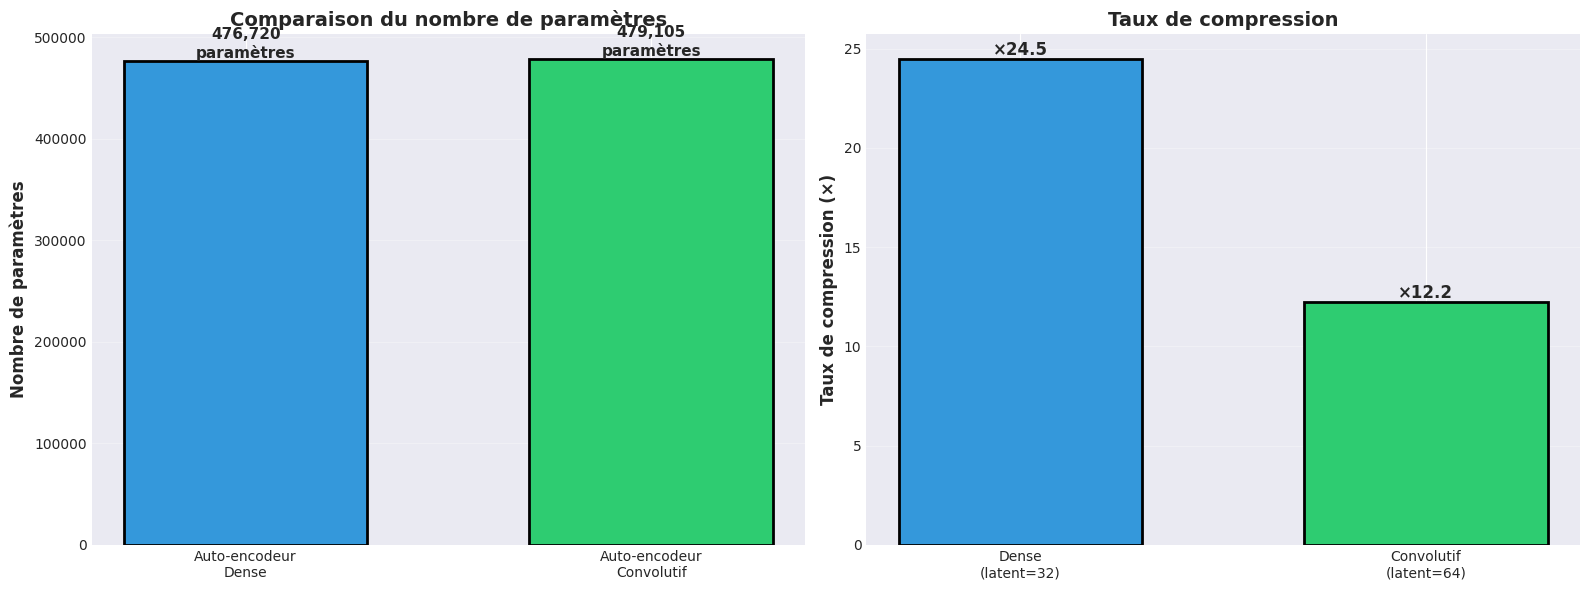


📊 Dense      : 476,720 paramètres | Latent: 32 dims
📊 Convolutif : 479,105 paramètres | Latent: 64 dims

⚠️  Le CNN a 2,385 paramètres de plus


In [18]:
# Comptage des paramètres
dense_total = dense_autoencoder.count_params()
conv_total = conv_autoencoder.count_params()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Comparaison du nombre de paramètres
models = ['Auto-encodeur\nDense', 'Auto-encodeur\nConvolutif']
params = [dense_total, conv_total]
colors = ['#3498db', '#2ecc71']

bars = ax1.bar(models, params, color=colors, edgecolor='black', linewidth=2, width=0.6)
ax1.set_ylabel('Nombre de paramètres', fontsize=12, fontweight='bold')
ax1.set_title('Comparaison du nombre de paramètres', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

for bar, param in zip(bars, params):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{param:,}\nparamètres',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

# Comparaison des dimensions latentes
latent_dims = ['Dense\n(latent=32)', 'Convolutif\n(latent=64)']
compression_ratios = [784/32, 784/64]
bars2 = ax2.bar(latent_dims, compression_ratios, color=colors, 
               edgecolor='black', linewidth=2, width=0.6)
ax2.set_ylabel('Taux de compression (×)', fontsize=12, fontweight='bold')
ax2.set_title('Taux de compression', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

for bar, ratio in zip(bars2, compression_ratios):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'×{ratio:.1f}',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n{'='*70}")
print(f"📊 Dense      : {dense_total:,} paramètres | Latent: 32 dims")
print(f"📊 Convolutif : {conv_total:,} paramètres | Latent: 64 dims")
if conv_total < dense_total:
    print(f"\n✅ Le CNN a {dense_total - conv_total:,} paramètres de moins !")
else:
    print(f"\n⚠️  Le CNN a {conv_total - dense_total:,} paramètres de plus")
print(f"{'='*70}")

### 5.4 Compilation et entraînement

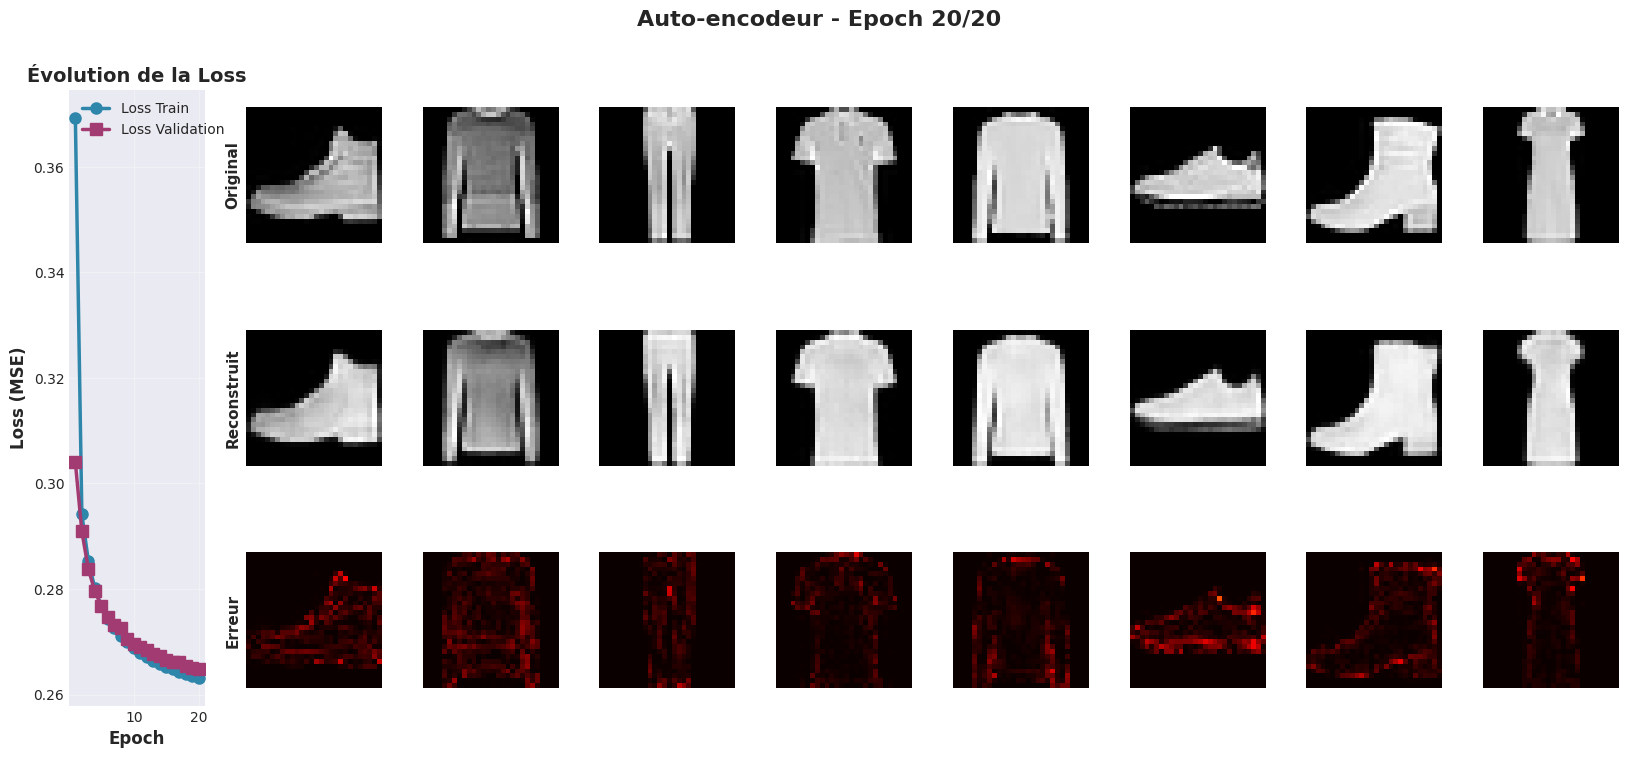


Epoch 20/20
Loss: 0.263215 - Val Loss: 0.264831
MSE moyenne sur échantillon: 0.002631

✅ Entraînement terminé !


In [19]:
# Compilation
conv_autoencoder.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['mse']
)

print("✅ Auto-encodeur convolutif compilé")

# Callback de visualisation
viz_callback_conv = AutoencoderVisualizationCallback(X_val_cnn, n_images=8)

print("\n🚀 Début de l'entraînement de l'auto-encodeur CONVOLUTIF...\n")

# Entraînement
history_conv = conv_autoencoder.fit(
    X_train_cnn, X_train_cnn,
    validation_data=(X_val_cnn, X_val_cnn),
    epochs=20,
    batch_size=256,
    callbacks=[viz_callback_conv],
    verbose=0
)

print("\n✅ Entraînement terminé !")

### 5.5 Évaluation et comparaison

📊 COMPARAISON FINALE
Dense      - Loss: 0.276847 | MSE: 0.011124 | RMSE: 0.105469
Convolutif - Loss: 0.265755 | MSE: 0.007623 | RMSE: 0.087312

🏆 Le CNN est meilleur de 31.47% !


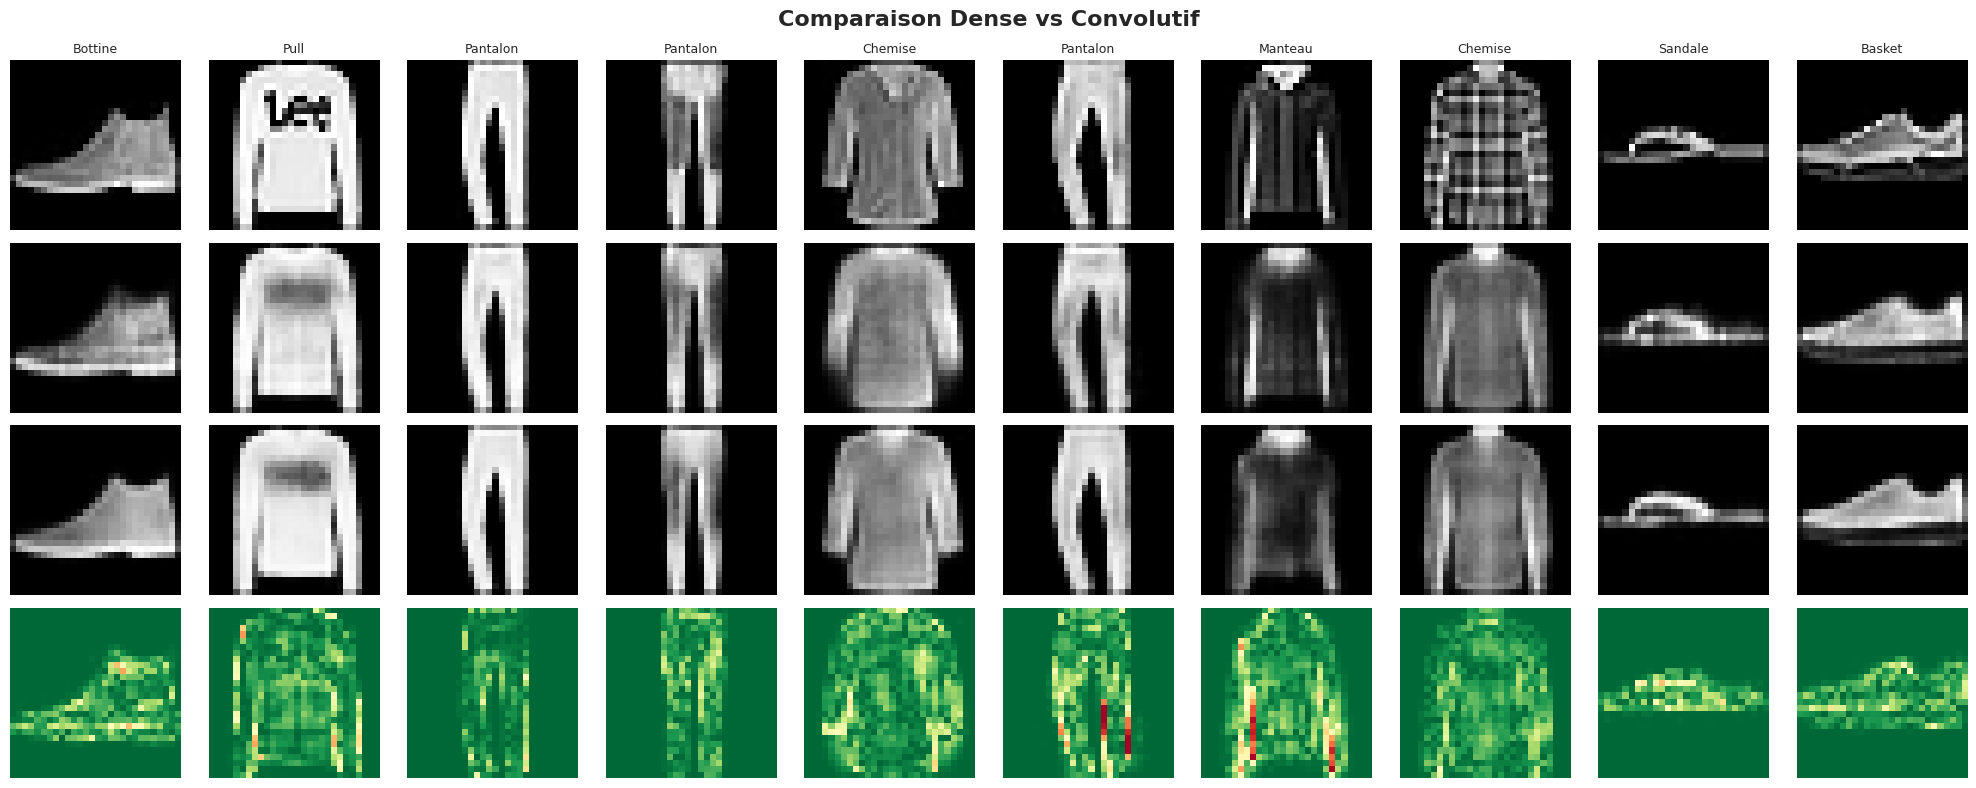

In [20]:
# Évaluation
conv_test_loss, conv_test_mse = conv_autoencoder.evaluate(X_test_cnn, X_test_cnn, verbose=0)

# Reconstruction d'exemples
n_examples = 10
test_sample_cnn = X_test_cnn[:n_examples]
reconstructed_conv = conv_autoencoder.predict(test_sample_cnn, verbose=0)

print("="*70)
print("📊 COMPARAISON FINALE")
print("="*70)
print(f"Dense      - Loss: {test_loss:.6f} | MSE: {test_mse:.6f} | RMSE: {np.sqrt(test_mse):.6f}")
print(f"Convolutif - Loss: {conv_test_loss:.6f} | MSE: {conv_test_mse:.6f} | RMSE: {np.sqrt(conv_test_mse):.6f}")
print("="*70)

if conv_test_mse < test_mse:
    improvement = ((test_mse - conv_test_mse) / test_mse) * 100
    print(f"\n🏆 Le CNN est meilleur de {improvement:.2f}% !")
else:
    print(f"\n🏆 Le Dense est meilleur !")

# Visualisation comparative
fig, axes = plt.subplots(4, n_examples, figsize=(20, 8))
fig.suptitle('Comparaison Dense vs Convolutif', fontsize=16, fontweight='bold')

# Prédictions Dense
reconstructed_dense = dense_autoencoder.predict(X_test_flat[:n_examples], verbose=0)

for i in range(n_examples):
    # Original
    axes[0, i].imshow(X_test[i], cmap='gray')
    axes[0, i].axis('off')
    if i == 0:
        axes[0, i].set_ylabel('Original', fontsize=12, fontweight='bold')
    axes[0, i].set_title(class_names[y_test[i]], fontsize=9)
    
    # Dense
    axes[1, i].imshow(reconstructed_dense[i].reshape(28, 28), cmap='gray')
    axes[1, i].axis('off')
    if i == 0:
        axes[1, i].set_ylabel('Dense', fontsize=12, fontweight='bold')
    mse_dense = np.mean((X_test_flat[i] - reconstructed_dense[i]) ** 2)
    axes[1, i].set_xlabel(f'MSE: {mse_dense:.4f}', fontsize=8)
    
    # Convolutif
    axes[2, i].imshow(reconstructed_conv[i].reshape(28, 28), cmap='gray')
    axes[2, i].axis('off')
    if i == 0:
        axes[2, i].set_ylabel('Convolutif', fontsize=12, fontweight='bold')
    mse_conv = np.mean((X_test_cnn[i] - reconstructed_conv[i]) ** 2)
    axes[2, i].set_xlabel(f'MSE: {mse_conv:.4f}', fontsize=8)
    
    # Différence
    diff = np.abs(reconstructed_conv[i].reshape(28, 28) - reconstructed_dense[i].reshape(28, 28))
    axes[3, i].imshow(diff, cmap='RdYlGn_r', vmin=0, vmax=0.5)
    axes[3, i].axis('off')
    if i == 0:
        axes[3, i].set_ylabel('Diff Conv-Dense', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

---

# PARTIE 3 : DENOISING AUTO-ENCODEUR

## 6. Débruitage d'images

### Principe

Un **denoising autoencoder** apprend à reconstruire des images propres à partir d'images bruitées :

```
Image propre → Ajout de bruit → Image bruitée → Encoder → Decoder → Image reconstruite (propre)
```

### Applications
- 📷 Restauration de vieilles photos
- 🎥 Amélioration de vidéos basse qualité
- 🔬 Débruitage d'images médicales
- 🛰️ Amélioration d'images satellites

### 6.1 Création de données bruitées

In [21]:
def add_noise(images, noise_factor=0.3):
    """
    Ajoute du bruit gaussien aux images.
    
    Args:
        images: Images normalisées [0, 1]
        noise_factor: Intensité du bruit
    
    Returns:
        Images bruitées, clippées entre [0, 1]
    """
    noisy_images = images + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=images.shape
    )
    noisy_images = np.clip(noisy_images, 0.0, 1.0)
    return noisy_images

# Création des données bruitées
noise_factor = 0.4

X_train_noisy = add_noise(X_train_cnn, noise_factor)
X_val_noisy = add_noise(X_val_cnn, noise_factor)
X_test_noisy = add_noise(X_test_cnn, noise_factor)

print(f"✅ Bruit ajouté avec facteur = {noise_factor}")
print(f"   Forme des données bruitées: {X_train_noisy.shape}")

✅ Bruit ajouté avec facteur = 0.4
   Forme des données bruitées: (50000, 28, 28, 1)


### 6.2 Visualisation du bruit

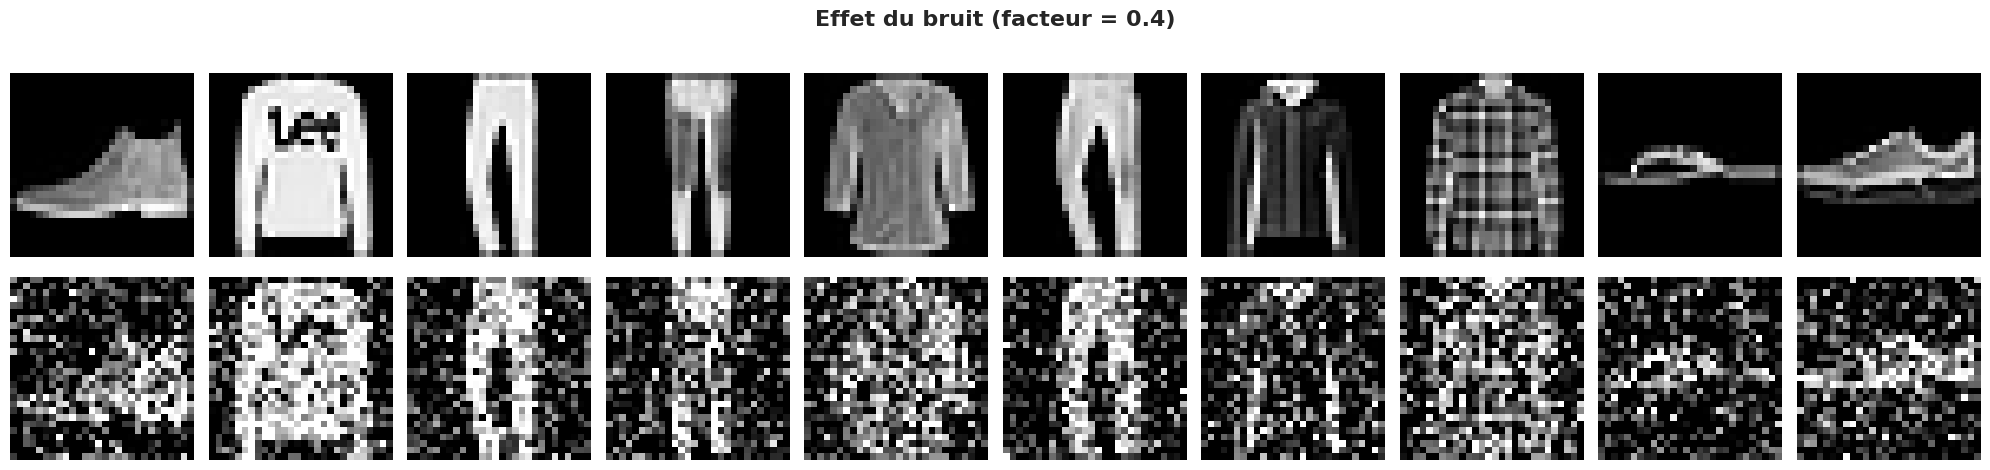

In [22]:
# Visualisation de l'effet du bruit
n_samples = 10

fig, axes = plt.subplots(2, n_samples, figsize=(20, 5))
fig.suptitle(f'Effet du bruit (facteur = {noise_factor})', fontsize=16, fontweight='bold')

for i in range(n_samples):
    # Image originale
    axes[0, i].imshow(X_test_cnn[i].reshape(28, 28), cmap='gray')
    axes[0, i].axis('off')
    if i == 0:
        axes[0, i].set_ylabel('Originale', fontsize=12, fontweight='bold')
    
    # Image bruitée
    axes[1, i].imshow(X_test_noisy[i].reshape(28, 28), cmap='gray')
    axes[1, i].axis('off')
    if i == 0:
        axes[1, i].set_ylabel('Bruitée', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

### 6.3 Entraînement du denoising autoencoder

**Note importante** : Nous utilisons la même architecture que l'auto-encodeur convolutif, mais avec un entraînement différent :
- **Input** : Images bruitées
- **Output cible** : Images propres

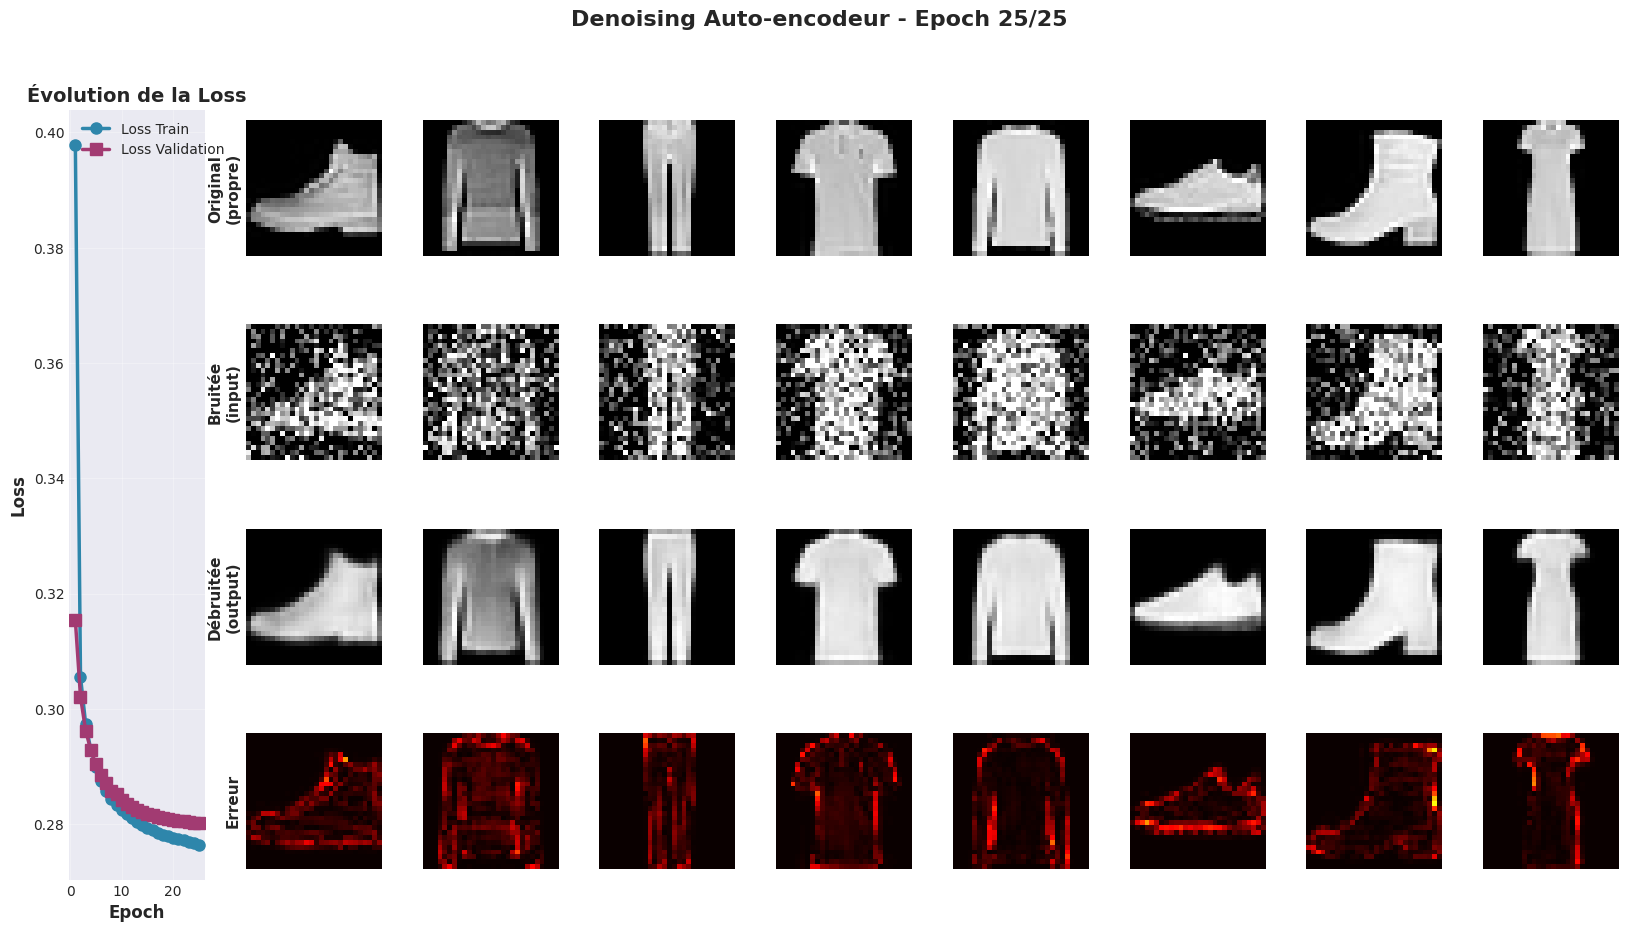


Epoch 25/25
Loss: 0.276446 - Val Loss: 0.280105

✅ Entraînement terminé !


In [23]:
# Création d'un nouveau modèle (même architecture)
denoising_autoencoder, denoising_encoder, denoising_decoder = create_convolutional_autoencoder(conv_latent_dim)

# Compilation
denoising_autoencoder.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['mse']
)

print("✅ Denoising auto-encodeur créé et compilé")

# Callback personnalisé pour denoising
class DenoisingVisualizationCallback(Callback):
    def __init__(self, noisy_data, clean_data, n_images=8):
        super().__init__()
        self.noisy_data = noisy_data[:n_images]
        self.clean_data = clean_data[:n_images]
        self.n_images = n_images
        
    def on_train_begin(self, logs=None):
        self.epochs = []
        self.loss = []
        self.val_loss = []
        
    def on_epoch_end(self, epoch, logs=None):
        self.epochs.append(epoch + 1)
        self.loss.append(logs.get('loss'))
        self.val_loss.append(logs.get('val_loss'))
        
        clear_output(wait=True)
        
        fig = plt.figure(figsize=(20, 10))
        gs = fig.add_gridspec(4, self.n_images + 1, hspace=0.3, wspace=0.3)
        
        # Graphique de la loss
        ax_loss = fig.add_subplot(gs[:, 0])
        ax_loss.plot(self.epochs, self.loss, 'o-', label='Loss Train', 
                    linewidth=2.5, markersize=8, color='#2E86AB')
        ax_loss.plot(self.epochs, self.val_loss, 's-', label='Loss Validation', 
                    linewidth=2.5, markersize=8, color='#A23B72')
        ax_loss.set_xlabel('Epoch', fontsize=12, fontweight='bold')
        ax_loss.set_ylabel('Loss', fontsize=12, fontweight='bold')
        ax_loss.set_title('Évolution de la Loss', fontsize=14, fontweight='bold')
        ax_loss.legend(fontsize=10)
        ax_loss.grid(alpha=0.3)
        
        # Prédictions
        denoised = self.model.predict(self.noisy_data, verbose=0)
        
        # Affichage
        for i in range(self.n_images):
            # Original propre
            ax = fig.add_subplot(gs[0, i + 1])
            ax.imshow(self.clean_data[i].reshape(28, 28), cmap='gray')
            if i == 0:
                ax.set_ylabel('Original\n(propre)', fontsize=11, fontweight='bold')
            ax.set_xticks([])
            ax.set_yticks([])
            
            # Bruitée (input)
            ax = fig.add_subplot(gs[1, i + 1])
            ax.imshow(self.noisy_data[i].reshape(28, 28), cmap='gray')
            if i == 0:
                ax.set_ylabel('Bruitée\n(input)', fontsize=11, fontweight='bold')
            ax.set_xticks([])
            ax.set_yticks([])
            
            # Débruitée (output)
            ax = fig.add_subplot(gs[2, i + 1])
            ax.imshow(denoised[i].reshape(28, 28), cmap='gray')
            if i == 0:
                ax.set_ylabel('Débruitée\n(output)', fontsize=11, fontweight='bold')
            ax.set_xticks([])
            ax.set_yticks([])
            
            # Erreur vs original
            ax = fig.add_subplot(gs[3, i + 1])
            diff = np.abs(self.clean_data[i].reshape(28, 28) - denoised[i].reshape(28, 28))
            ax.imshow(diff, cmap='hot', vmin=0, vmax=1)
            if i == 0:
                ax.set_ylabel('Erreur', fontsize=11, fontweight='bold')
            ax.set_xticks([])
            ax.set_yticks([])
        
        plt.suptitle(f'Denoising Auto-encodeur - Epoch {epoch + 1}/{self.params["epochs"]}', 
                    fontsize=16, fontweight='bold', y=0.98)
        plt.show()
        
        print(f"\nEpoch {epoch + 1}/{self.params['epochs']}")
        print(f"Loss: {logs.get('loss'):.6f} - Val Loss: {logs.get('val_loss'):.6f}")

# Callback
denoising_viz_callback = DenoisingVisualizationCallback(X_val_noisy, X_val_cnn, n_images=8)

print("\n🚀 Début de l'entraînement du DENOISING auto-encodeur...\n")

# Entraînement: INPUT = bruitée, OUTPUT = propre
history_denoising = denoising_autoencoder.fit(
    X_train_noisy, X_train_cnn,  # Input bruitée, output propre
    validation_data=(X_val_noisy, X_val_cnn),
    epochs=25,
    batch_size=256,
    callbacks=[denoising_viz_callback],
    verbose=0
)

print("\n✅ Entraînement terminé !")

### 6.4 Évaluation du denoising autoencoder

📊 RÉSULTATS - DENOISING AUTO-ENCODEUR
Loss sur le test: 0.281101
MSE sur le test: 0.012304

📊 PSNR (Peak Signal-to-Noise Ratio):
   Images bruitées:  10.87 dB
   Images débruitées: 19.14 dB
   Amélioration: 8.27 dB


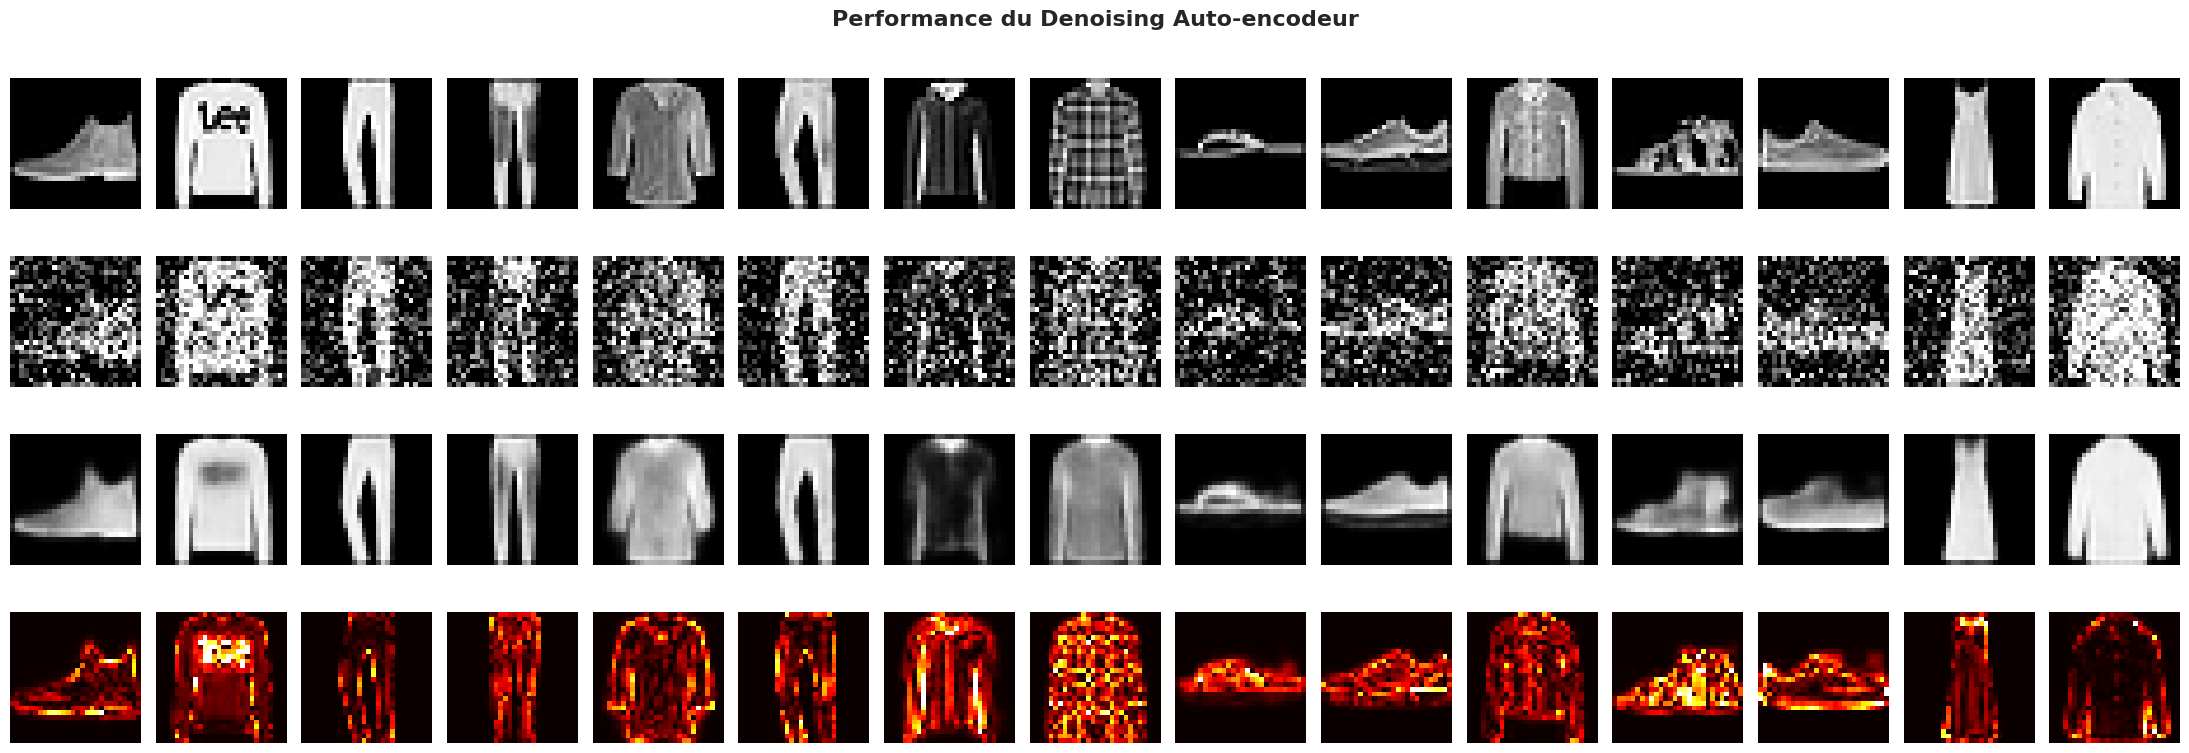


✅ Le denoising auto-encodeur réduit significativement le bruit !


In [24]:
# Évaluation
denoising_test_loss, denoising_test_mse = denoising_autoencoder.evaluate(
    X_test_noisy, X_test_cnn, verbose=0
)

# Débruitage d'exemples
n_examples = 15
test_noisy_sample = X_test_noisy[:n_examples]
test_clean_sample = X_test_cnn[:n_examples]
denoised_images = denoising_autoencoder.predict(test_noisy_sample, verbose=0)

print("="*70)
print("📊 RÉSULTATS - DENOISING AUTO-ENCODEUR")
print("="*70)
print(f"Loss sur le test: {denoising_test_loss:.6f}")
print(f"MSE sur le test: {denoising_test_mse:.6f}")
print("="*70)

# Calcul des métriques de qualité
# PSNR (Peak Signal-to-Noise Ratio) - Plus c'est élevé, mieux c'est
def calculate_psnr(original, reconstructed):
    mse = np.mean((original - reconstructed) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 1.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

psnr_noisy = calculate_psnr(test_clean_sample, test_noisy_sample)
psnr_denoised = calculate_psnr(test_clean_sample, denoised_images)

print(f"\n📊 PSNR (Peak Signal-to-Noise Ratio):")
print(f"   Images bruitées:  {psnr_noisy:.2f} dB")
print(f"   Images débruitées: {psnr_denoised:.2f} dB")
print(f"   Amélioration: {psnr_denoised - psnr_noisy:.2f} dB")

# Visualisation détaillée
fig, axes = plt.subplots(4, n_examples, figsize=(22, 8))
fig.suptitle('Performance du Denoising Auto-encodeur', fontsize=16, fontweight='bold')

for i in range(n_examples):
    # Original propre
    axes[0, i].imshow(test_clean_sample[i].reshape(28, 28), cmap='gray')
    axes[0, i].axis('off')
    if i == 0:
        axes[0, i].set_ylabel('Original\n(propre)', fontsize=11, fontweight='bold')
    
    # Bruitée
    axes[1, i].imshow(test_noisy_sample[i].reshape(28, 28), cmap='gray')
    axes[1, i].axis('off')
    if i == 0:
        axes[1, i].set_ylabel('Bruitée', fontsize=11, fontweight='bold')
    # MSE avec original
    mse_noisy = np.mean((test_clean_sample[i] - test_noisy_sample[i]) ** 2)
    axes[1, i].set_xlabel(f'MSE: {mse_noisy:.4f}', fontsize=8, color='red')
    
    # Débruitée
    axes[2, i].imshow(denoised_images[i].reshape(28, 28), cmap='gray')
    axes[2, i].axis('off')
    if i == 0:
        axes[2, i].set_ylabel('Débruitée', fontsize=11, fontweight='bold')
    # MSE avec original
    mse_denoised = np.mean((test_clean_sample[i] - denoised_images[i]) ** 2)
    axes[2, i].set_xlabel(f'MSE: {mse_denoised:.4f}', fontsize=8, color='green')
    
    # Erreur résiduelle
    diff = np.abs(test_clean_sample[i].reshape(28, 28) - denoised_images[i].reshape(28, 28))
    axes[3, i].imshow(diff, cmap='hot', vmin=0, vmax=0.5)
    axes[3, i].axis('off')
    if i == 0:
        axes[3, i].set_ylabel('Erreur\nrésiduelle', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n✅ Le denoising auto-encodeur réduit significativement le bruit !")

---

## 7. Applications pratiques des auto-encodeurs

### 7.1 Détection d'anomalies

Les auto-encodeurs sont excellents pour détecter des anomalies :
- Entraîner sur des données "normales"
- Les anomalies produisent une erreur de reconstruction élevée

🔍 Simulation de détection d'anomalies...
   Concept: Entraîner uniquement sur une classe, détecter les autres

📦 Entraînement sur 4977 T-shirts uniquement
⏳ Entraînement rapide (10 epochs)...
✅ Entraînement terminé



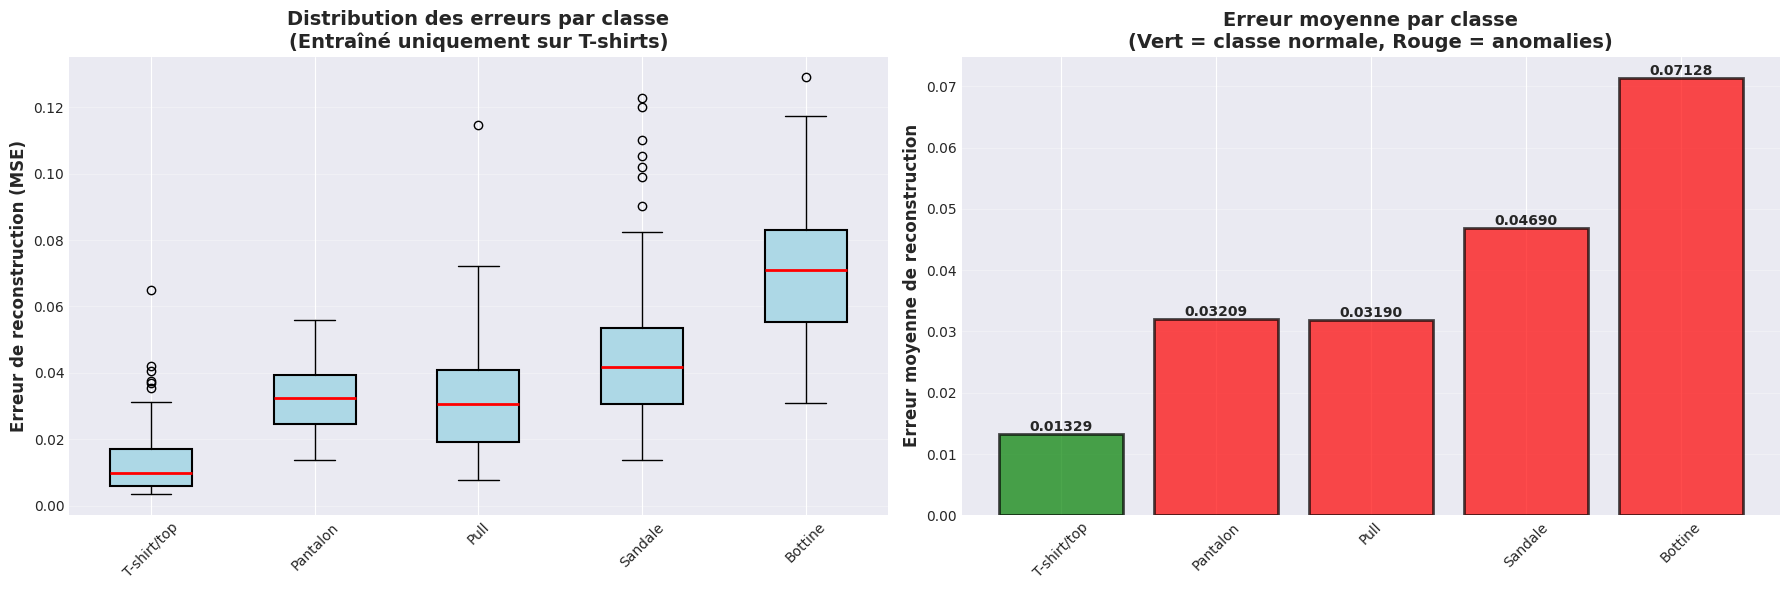


📊 ANALYSE:
   Erreur moyenne sur T-shirts (normal): 0.01329
   Erreur moyenne sur autres classes: 0.04554
   Ratio d'augmentation: ×3.43

💡 Les anomalies (classes non vues) ont une erreur beaucoup plus élevée !


In [25]:
# Simulation de détection d'anomalies
# Entraînons un auto-encodeur uniquement sur les T-shirts (classe 0)

print("🔍 Simulation de détection d'anomalies...")
print("   Concept: Entraîner uniquement sur une classe, détecter les autres\n")

# Filtrage: uniquement les T-shirts pour l'entraînement
tshirt_mask = y_train_final == 0
X_train_tshirts = X_train_cnn[tshirt_mask][:5000]  # 5000 T-shirts

print(f"📦 Entraînement sur {len(X_train_tshirts)} T-shirts uniquement")

# Création et entraînement rapide
anomaly_ae, _, _ = create_convolutional_autoencoder(latent_dim=32)
anomaly_ae.compile(optimizer='adam', loss='mse', metrics=['mse'])

print("⏳ Entraînement rapide (10 epochs)...")
anomaly_ae.fit(
    X_train_tshirts, X_train_tshirts,
    epochs=10,
    batch_size=128,
    verbose=0
)
print("✅ Entraînement terminé\n")

# Test sur différentes classes
classes_to_test = [0, 1, 2, 5, 9]  # T-shirt, Pantalon, Pull, Sandale, Bottine
reconstruction_errors = {}

for class_idx in classes_to_test:
    # Sélection de 100 exemples de cette classe
    mask = y_test == class_idx
    X_class = X_test_cnn[mask][:100]
    
    # Reconstruction
    reconstructed = anomaly_ae.predict(X_class, verbose=0)
    
    # Calcul de l'erreur de reconstruction
    mse_per_image = np.mean((X_class - reconstructed) ** 2, axis=(1, 2, 3))
    reconstruction_errors[class_names[class_idx]] = mse_per_image

# Visualisation des erreurs de reconstruction
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Boxplot
ax1.boxplot(
    [reconstruction_errors[class_names[i]] for i in classes_to_test],
    labels=[class_names[i] for i in classes_to_test],
    patch_artist=True,
    boxprops=dict(facecolor='lightblue', edgecolor='black', linewidth=1.5),
    medianprops=dict(color='red', linewidth=2)
)
ax1.set_ylabel('Erreur de reconstruction (MSE)', fontsize=12, fontweight='bold')
ax1.set_title('Distribution des erreurs par classe\n(Entraîné uniquement sur T-shirts)', 
             fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# Moyennes
means = [np.mean(reconstruction_errors[class_names[i]]) for i in classes_to_test]
colors_bar = ['green' if i == 0 else 'red' for i in classes_to_test]
bars = ax2.bar([class_names[i] for i in classes_to_test], means, 
               color=colors_bar, edgecolor='black', linewidth=2, alpha=0.7)
ax2.set_ylabel('Erreur moyenne de reconstruction', fontsize=12, fontweight='bold')
ax2.set_title('Erreur moyenne par classe\n(Vert = classe normale, Rouge = anomalies)', 
             fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

for bar, mean in zip(bars, means):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{mean:.5f}',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n📊 ANALYSE:")
print(f"   Erreur moyenne sur T-shirts (normal): {means[0]:.5f}")
print(f"   Erreur moyenne sur autres classes: {np.mean(means[1:]):.5f}")
print(f"   Ratio d'augmentation: ×{np.mean(means[1:]) / means[0]:.2f}")
print("\n💡 Les anomalies (classes non vues) ont une erreur beaucoup plus élevée !")

### 7.2 Exploration de l'espace latent - Génération d'images

Nous pouvons explorer l'espace latent pour générer de nouvelles images.

🎨 Exploration de l'espace latent...



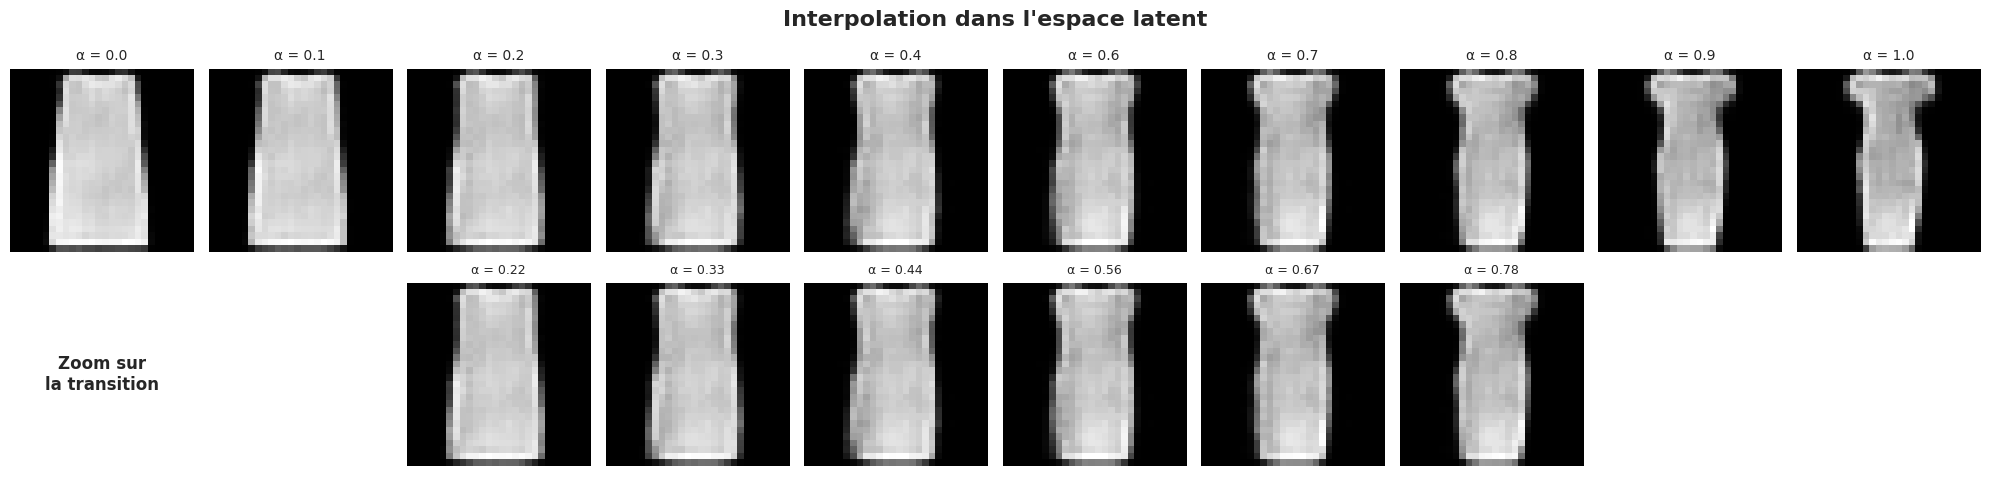


💡 OBSERVATION:
   L'interpolation dans l'espace latent produit des transitions douces
   entre les deux images, montrant que l'espace est bien structuré !

   Image 1: Robe
   Image 2: Robe


In [26]:
# Encodage de quelques images de référence
print("🎨 Exploration de l'espace latent...\n")

# Sélection de 2 images différentes
idx1, idx2 = 42, 100
img1 = X_test_cnn[idx1:idx1+1]
img2 = X_test_cnn[idx2:idx2+1]

# Encodage
z1 = conv_encoder.predict(img1, verbose=0)
z2 = conv_encoder.predict(img2, verbose=0)

# Interpolation linéaire dans l'espace latent
n_steps = 10
alphas = np.linspace(0, 1, n_steps)
interpolated_images = []

for alpha in alphas:
    # Interpolation: z = (1-α)*z1 + α*z2
    z_interpolated = (1 - alpha) * z1 + alpha * z2
    # Décodage
    img_interpolated = conv_decoder.predict(z_interpolated, verbose=0)
    interpolated_images.append(img_interpolated[0])

# Visualisation
fig, axes = plt.subplots(2, n_steps, figsize=(20, 5))
fig.suptitle('Interpolation dans l\'espace latent', fontsize=16, fontweight='bold')

# Images originales et interpolées
for i, alpha in enumerate(alphas):
    axes[0, i].imshow(interpolated_images[i].reshape(28, 28), cmap='gray')
    axes[0, i].axis('off')
    axes[0, i].set_title(f'α = {alpha:.1f}', fontsize=10)
    
    # Marquer les images de départ et d'arrivée
    if i == 0:
        axes[0, i].set_xlabel('Image 1\n(départ)', fontsize=9, color='blue', fontweight='bold')
    elif i == n_steps - 1:
        axes[0, i].set_xlabel('Image 2\n(arrivée)', fontsize=9, color='red', fontweight='bold')

# Deuxième ligne: zoom sur le milieu de l'interpolation
middle_indices = [2, 3, 4, 5, 6, 7]
for i, idx in enumerate(middle_indices):
    axes[1, i+2].imshow(interpolated_images[idx].reshape(28, 28), cmap='gray')
    axes[1, i+2].axis('off')
    axes[1, i+2].set_title(f'α = {alphas[idx]:.2f}', fontsize=9)

# Masquer les axes inutilisés
for i in [0, 1, 8, 9]:
    axes[1, i].axis('off')

axes[1, 0].text(0.5, 0.5, 'Zoom sur\nla transition', 
               ha='center', va='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n💡 OBSERVATION:")
print("   L'interpolation dans l'espace latent produit des transitions douces")
print("   entre les deux images, montrant que l'espace est bien structuré !")
print(f"\n   Image 1: {class_names[y_test[idx1]]}")
print(f"   Image 2: {class_names[y_test[idx2]]}")

### 7.3 Génération aléatoire depuis l'espace latent

🎲 Génération d'images aléatoires depuis l'espace latent...

📊 Statistiques de l'espace latent (sur 1000 exemples):
   Moyenne: 3.6496 ± 3.2612
   Écart-type: 2.2277 ± 1.7685



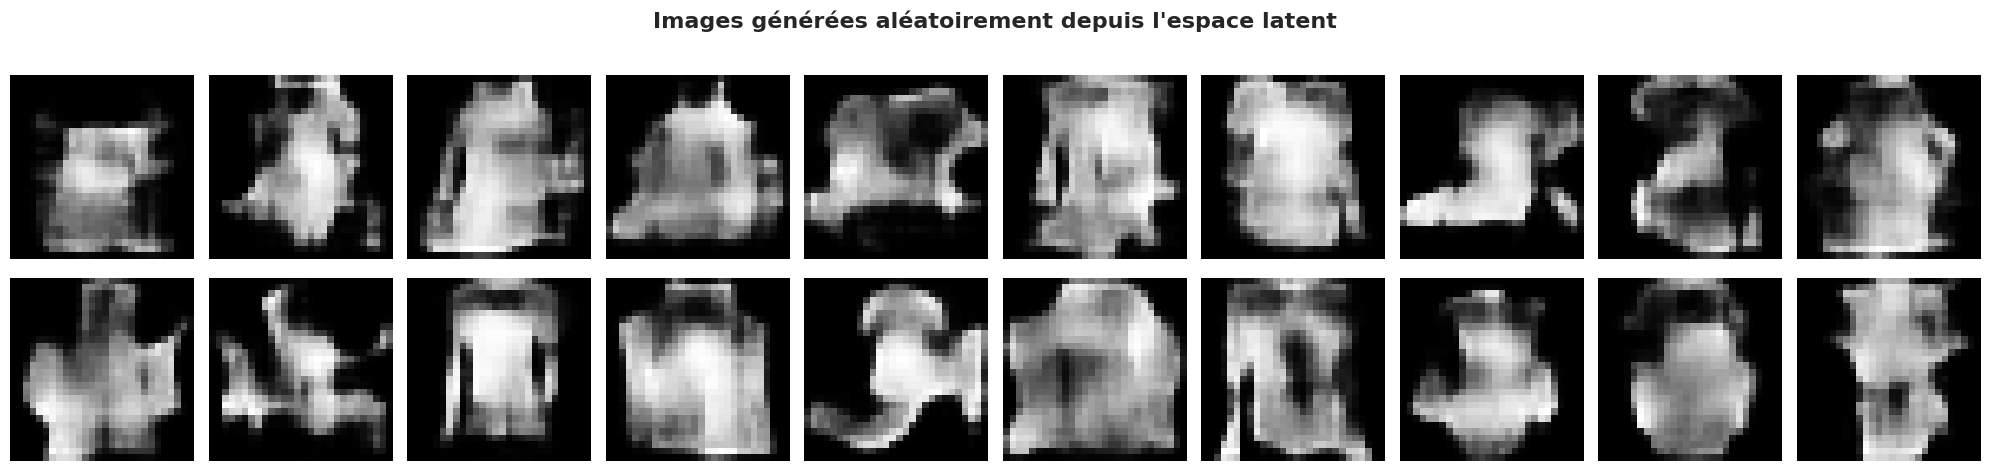


💡 OBSERVATION:
   Certaines images ressemblent à des vêtements réalistes,
   d'autres sont plus floues ou abstraites.
   ⚠️  Pour une meilleure génération, utilisez des VAE (Variational Autoencoders) !


In [27]:
# Génération d'images aléatoires
print("🎲 Génération d'images aléatoires depuis l'espace latent...\n")

# Analyse de la distribution de l'espace latent
all_latent = conv_encoder.predict(X_test_cnn[:1000], verbose=0)
latent_mean = np.mean(all_latent, axis=0)
latent_std = np.std(all_latent, axis=0)

print(f"📊 Statistiques de l'espace latent (sur 1000 exemples):")
print(f"   Moyenne: {latent_mean.mean():.4f} ± {latent_mean.std():.4f}")
print(f"   Écart-type: {latent_std.mean():.4f} ± {latent_std.std():.4f}\n")

# Génération de codes latents aléatoires
n_random = 20
random_latents = np.random.normal(latent_mean, latent_std, size=(n_random, conv_latent_dim))

# Décodage
random_images = conv_decoder.predict(random_latents, verbose=0)

# Visualisation
fig, axes = plt.subplots(2, 10, figsize=(20, 5))
fig.suptitle('Images générées aléatoirement depuis l\'espace latent', 
            fontsize=16, fontweight='bold')

for i in range(n_random):
    row = i // 10
    col = i % 10
    axes[row, col].imshow(random_images[i].reshape(28, 28), cmap='gray')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

print("\n💡 OBSERVATION:")
print("   Certaines images ressemblent à des vêtements réalistes,")
print("   d'autres sont plus floues ou abstraites.")
print("   ⚠️  Pour une meilleure génération, utilisez des VAE (Variational Autoencoders) !")

---

## 8. Conclusion et Comparaison Finale

### 8.1 Tableau récapitulatif


📊 COMPARAISON FINALE DES AUTO-ENCODEURS
      Modèle Architecture Paramètres  Latent Dim MSE Test               Cas d'usage
    Dense AE        Dense    476,720          32 0.011124           Général, simple
     Conv AE   Convolutif    479,105          64 0.007623 Images, meilleure qualité
Denoising AE   Convolutif    479,105          64 0.012304    Débruitage, robustesse


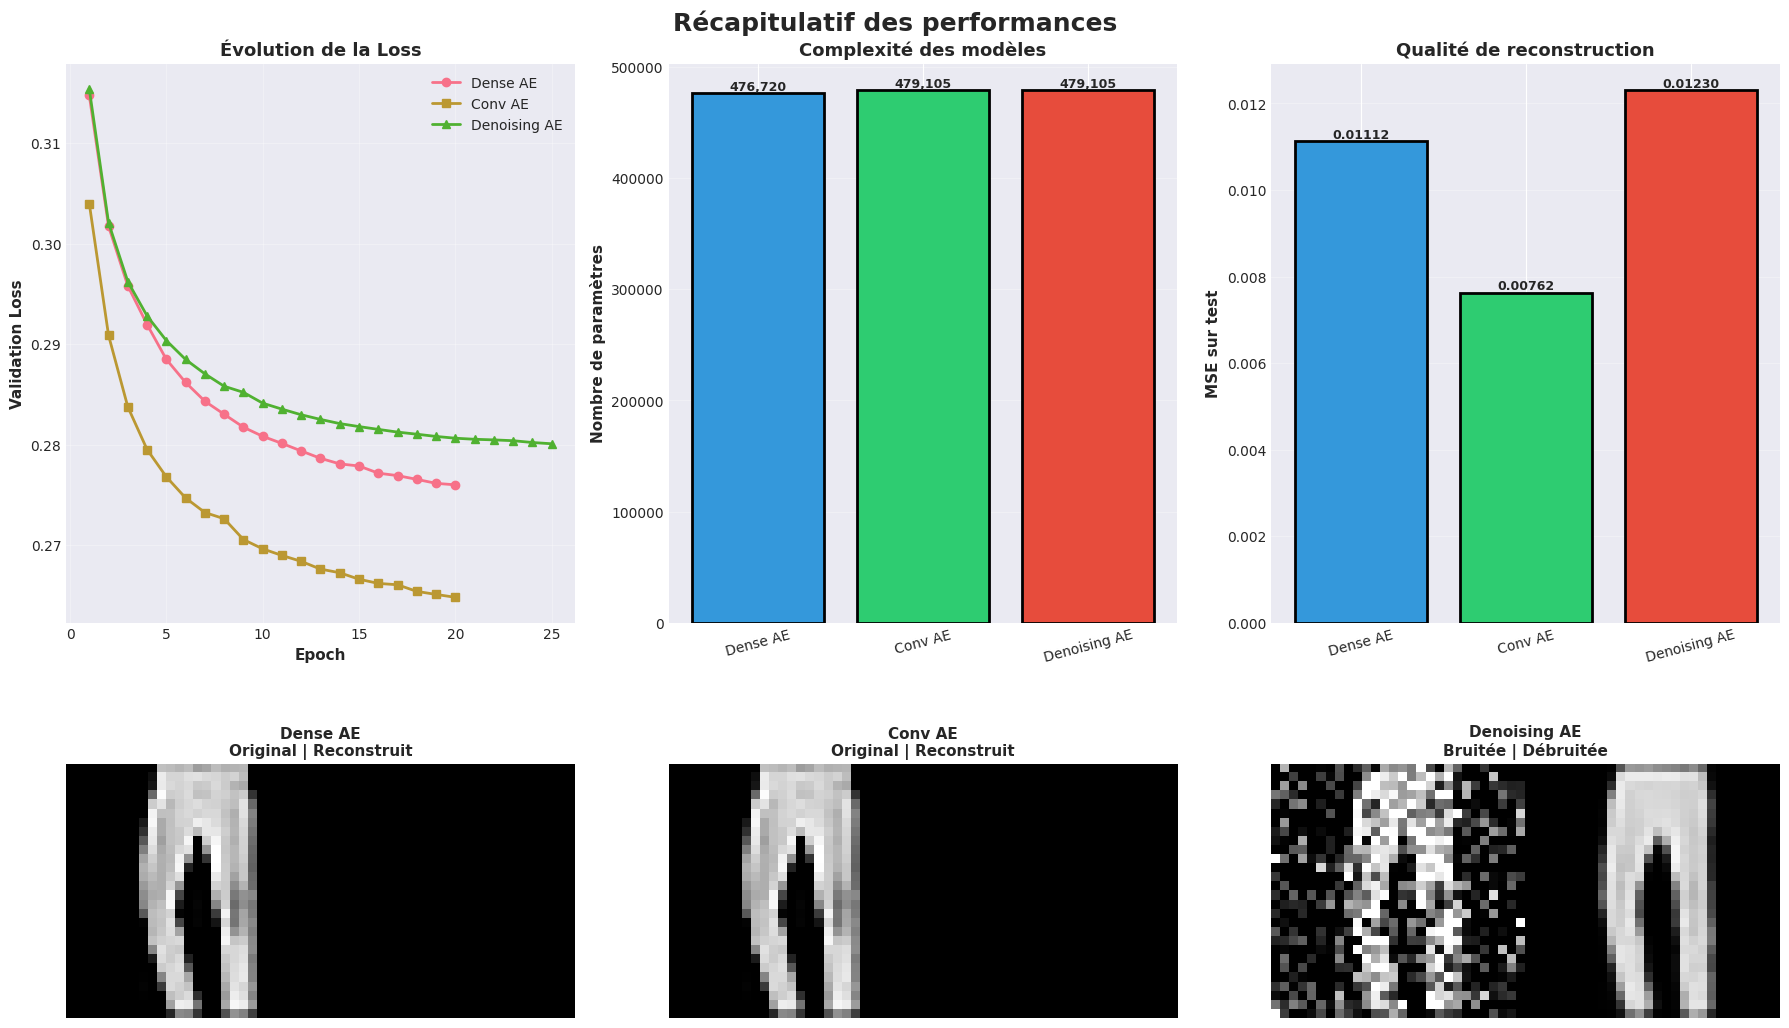

In [28]:
import pandas as pd

# Création du tableau comparatif
comparison_data = {
    'Modèle': ['Dense AE', 'Conv AE', 'Denoising AE'],
    'Architecture': ['Dense', 'Convolutif', 'Convolutif'],
    'Paramètres': [
        f"{dense_autoencoder.count_params():,}",
        f"{conv_autoencoder.count_params():,}",
        f"{denoising_autoencoder.count_params():,}"
    ],
    'Latent Dim': [32, 64, 64],
    'MSE Test': [
        f"{test_mse:.6f}",
        f"{conv_test_mse:.6f}",
        f"{denoising_test_mse:.6f}"
    ],
    'Cas d\'usage': [
        'Général, simple',
        'Images, meilleure qualité',
        'Débruitage, robustesse'
    ]
}

df = pd.DataFrame(comparison_data)

print("\n" + "="*90)
print("📊 COMPARAISON FINALE DES AUTO-ENCODEURS")
print("="*90)
print(df.to_string(index=False))
print("="*90)

# Visualisation finale
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Récapitulatif des performances', fontsize=18, fontweight='bold')

# Graphique 1: Courbes de loss
ax = axes[0, 0]
epochs = range(1, 21)
ax.plot(epochs, history_dense.history['val_loss'], 'o-', label='Dense AE', linewidth=2)
ax.plot(epochs, history_conv.history['val_loss'], 's-', label='Conv AE', linewidth=2)
ax.plot(range(1, 26), history_denoising.history['val_loss'], '^-', label='Denoising AE', linewidth=2)
ax.set_xlabel('Epoch', fontsize=11, fontweight='bold')
ax.set_ylabel('Validation Loss', fontsize=11, fontweight='bold')
ax.set_title('Évolution de la Loss', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(alpha=0.3)

# Graphique 2: Comparaison paramètres
ax = axes[0, 1]
models = ['Dense AE', 'Conv AE', 'Denoising AE']
params_list = [
    dense_autoencoder.count_params(),
    conv_autoencoder.count_params(),
    denoising_autoencoder.count_params()
]
colors = ['#3498db', '#2ecc71', '#e74c3c']
bars = ax.bar(models, params_list, color=colors, edgecolor='black', linewidth=2)
ax.set_ylabel('Nombre de paramètres', fontsize=11, fontweight='bold')
ax.set_title('Complexité des modèles', fontsize=13, fontweight='bold')
ax.tick_params(axis='x', rotation=15)
ax.grid(axis='y', alpha=0.3)
for bar, p in zip(bars, params_list):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
           f'{p:,}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Graphique 3: MSE finale
ax = axes[0, 2]
mse_list = [test_mse, conv_test_mse, denoising_test_mse]
bars = ax.bar(models, mse_list, color=colors, edgecolor='black', linewidth=2)
ax.set_ylabel('MSE sur test', fontsize=11, fontweight='bold')
ax.set_title('Qualité de reconstruction', fontsize=13, fontweight='bold')
ax.tick_params(axis='x', rotation=15)
ax.grid(axis='y', alpha=0.3)
for bar, mse in zip(bars, mse_list):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
           f'{mse:.5f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Exemples de reconstruction - Dense
ax = axes[1, 0]
test_idx = 5
recon_dense = dense_autoencoder.predict(X_test_flat[test_idx:test_idx+1], verbose=0)
comparison = np.hstack([X_test[test_idx], recon_dense.reshape(28, 28)])
ax.imshow(comparison, cmap='gray')
ax.set_title('Dense AE\nOriginal | Reconstruit', fontsize=11, fontweight='bold')
ax.axis('off')

# Exemples de reconstruction - Conv
ax = axes[1, 1]
recon_conv = conv_autoencoder.predict(X_test_cnn[test_idx:test_idx+1], verbose=0)
comparison = np.hstack([X_test[test_idx], recon_conv.reshape(28, 28)])
ax.imshow(comparison, cmap='gray')
ax.set_title('Conv AE\nOriginal | Reconstruit', fontsize=11, fontweight='bold')
ax.axis('off')

# Exemples de débruitage
ax = axes[1, 2]
denoised = denoising_autoencoder.predict(X_test_noisy[test_idx:test_idx+1], verbose=0)
comparison = np.hstack([X_test_noisy[test_idx].reshape(28, 28), denoised.reshape(28, 28)])
ax.imshow(comparison, cmap='gray')
ax.set_title('Denoising AE\nBruitée | Débruitée', fontsize=11, fontweight='bold')
ax.axis('off')

plt.tight_layout()
plt.show()

### 8.2 Points clés à retenir

#### 🎯 Architecture
- **Dense AE** : Simple, bon point de départ
- **Conv AE** : Meilleur pour les images, moins de paramètres
- **Denoising AE** : Robuste, apprend des représentations plus riches

#### 📊 Performance
- Les CNN produisent des reconstructions plus nettes
- Le denoising améliore la qualité des features apprises
- L'espace latent capture les caractéristiques essentielles

#### 💡 Applications
1. **Compression** : Réduire la taille des données
2. **Débruitage** : Nettoyer des images bruitées
3. **Détection d'anomalies** : Identifier des données inhabituelles
4. **Génération** : Créer de nouvelles données (avec VAE)
5. **Pre-training** : Initialiser des réseaux pour d'autres tâches
6. **Feature extraction** : Extraire des représentations utiles

#### ⚙️ Hyperparamètres importants
- **Dimension latente** : Trade-off compression vs qualité
- **Architecture** : Plus profonde = meilleures features
- **Fonction de loss** : MSE pour pixel par pixel, BCE pour probabilités
- **Dropout** : Régularisation, évite l'overfitting

### 🚀 Pour aller plus loin

1. **VAE (Variational Autoencoder)** : Génération probabiliste
2. **Sparse Autoencoder** : Régularisation par sparsité
3. **Contractive Autoencoder** : Robustesse aux perturbations
4. **Adversarial Autoencoder** : Combinaison avec GAN
5. **U-Net** : Architecture encoder-decoder pour segmentation
6. **Transformer Autoencoder** : Avec mécanisme d'attention

### 📚 Ressources
- [Auto-Encoding Variational Bayes (Kingma & Welling, 2013)](https://arxiv.org/abs/1312.6114)
- [Denoising Autoencoders (Vincent et al., 2008)](https://www.cs.toronto.edu/~larocheh/publications/icml-2008-denoising-autoencoders.pdf)
- [Keras Autoencoders Tutorial](https://blog.keras.io/building-autoencoders-in-keras.html)

## 9. Exercices pratiques

Pour approfondir votre compréhension, voici quelques exercices :

### Exercice 1 : Modifier la dimension latente
- Testez différentes dimensions latentes (8, 16, 64, 128)
- Observez l'impact sur la qualité de reconstruction
- Visualisez le trade-off compression vs qualité

### Exercice 2 : Architecture plus profonde
- Ajoutez des couches convolutives supplémentaires
- Utilisez Batch Normalization
- Comparez les performances

### Exercice 3 : Autres types de bruit
- Testez du bruit salt-and-pepper (pixels aléatoires noirs ou blancs)
- Ajoutez du bruit par blocs (masquer des régions)
- Évaluez la robustesse du denoising AE

### Exercice 4 : Transfer learning
- Utilisez l'encoder pré-entraîné pour une tâche de classification
- Comparez avec un entraînement from scratch
- Mesurez le gain de performance

### Exercice 5 : Autres datasets
- Appliquez les auto-encodeurs sur MNIST (chiffres)
- Testez sur CIFAR-10 (images couleur 32×32)
- Adaptez l'architecture si nécessaire

### Exercice 6 : VAE simple
- Implémentez un Variational Autoencoder basique
- Ajoutez une loss KL-divergence
- Générez de nouvelles images en échantillonnant

**Bon apprentissage ! 🚀**